# Exploratory Data Analysis

In [19]:
from py2neo import authenticate, NodeSelector, Graph, Node, Relationship

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pickle
import math
from IPython.display import display, HTML

In [ ]:
# set up authentication parameters
authenticate("localhost:7474", "my_neo4j_user", "my_neo4j_password")

In [2]:
authenticate("localhost:7474", "neo4j", "kombucha")

In [3]:
# connect to authenticated graph database
graph = Graph("http://localhost:7474/db/data/")

In [4]:
lang_dict = {'DE': 'German', 'EN': 'English', 'ES': 'Spanish', 'FA': 'Persian', 'RU': 'Russian', 'FR': 'French', \
                 'IT': 'Italian', 'JA': 'Japanese', 'PL': 'Polish', 'PT': 'Portuguese', 'ZH': 'Chinese'}


In [5]:
lang_dict_test = {'FA': 'Persian', 'PL': 'Polish'}

## Network properties

Network properties describe the shape and structure of a graph.

### Webpage-to-article graph
First, lets take a look at the entire data that we have loaded into separate graphs per language domains. This data includes both Article nodes and ExternalSource nodes. ExternalSource nodes are just categories of external webpages from which users came to Wikipedia articles, and they tend to be connected to lots of articles.

#### Graph size
Graph size is the number of nodes and/or edges in a network. In the webpage-to-article graph, we have two kinds of nodes: Articles and ExternalSources. Each language domain graph has 5 ExternalSource nodes, and we will calculate the counts of Article nodes and all edges in the function below.

In [7]:
def graph_size(language_code):
    articles_count = graph.data("""
        MATCH (n1:Article {language_code: {lang_code} }) 
        RETURN count(n1) as articles_count;
        """, lang_code = language_code)[0]
    
    # this is 5 for all graphs here (hardcoded below to save query time)
    # external_sources_count = graph.data("""
    #    MATCH (n1:ExternalSource {language_code: {lang_code} }) 
    #    RETURN count(n1) as r;
    #    """, lang_code = language_code)[0]
    
    # all edges terminate at articles, but they can start at either articles or externalSource
    edges_count = graph.data("""
        MATCH ()-[r1:REFERRED_TO]->(n1:Article {language_code: {lang_code} }) 
        RETURN count(r1) as edges_count;
        """, lang_code = language_code)[0]
    
    # weigh each edge by the count of references that went through it
    references_count = graph.data("""
        MATCH ()-[r1:REFERRED_TO]->(n1:Article {language_code: {lang_code} }) 
        RETURN sum(toInt(r1.count)) as references_count;
        """, lang_code = language_code)[0]
    
    
    d = dict(articles_count, **edges_count, **references_count)
    d['external_sources_count'] = 5
    d['language_code'] = language_code
    return d

In [8]:
graph_size('FA')

{'articles_count': 170187,
 'edges_count': 375565,
 'external_sources_count': 5,
 'language_code': 'FA',
 'references_count': 74059745}

In [28]:
w2a_graph_sizes_list = []
for lang in list(lang_dict.keys()):
    graph_dict = graph_size(lang)
    
    graph_dict['language'] = lang_dict[graph_dict['language_code']]
    # average references per edge
    graph_dict['refs_per_edge_avg'] = round(graph_dict['references_count'] * 1.0/graph_dict['edges_count'], 2)
    
    w2a_graph_sizes_list.append(graph_dict)
    print("Finished " + lang)
    
    
w2a_graph_sizes_df = pd.DataFrame(w2a_graph_sizes_list)
# reorder columns
w2a_graph_sizes_df = w2a_graph_sizes_df[['language', 'language_code', 'articles_count', \
                                         'external_sources_count', 'edges_count', 'references_count', 'refs_per_edge_avg']]
w2a_graph_sizes_df = w2a_graph_sizes_df.sort_values(by='articles_count', ascending=False)
w2a_graph_sizes_df


Finished DE
Finished RU
Finished FA
Finished FR
Finished ZH
Finished IT
Finished PT
Finished ES
Finished PL
Finished EN
Finished JA


,language,language_code,articles_count,external_sources_count,edges_count,references_count,refs_per_edge_avg
9,English,EN,4636312,5,25917378,7209691324,278.18
1,Russian,RU,1310230,5,2712051,704827086,259.89
0,German,DE,1307048,5,5305000,775318583,146.15
3,French,FR,1018507,5,3545691,584620558,164.88
10,Japanese,JA,880747,5,2295941,765429220,333.38
7,Spanish,ES,802360,5,3409055,915554698,268.57
5,Italian,IT,698313,5,2919343,476970761,163.38
6,Portuguese,PT,523616,5,1773920,315514276,177.86
4,Chinese,ZH,497074,5,1238296,291813076,235.66
8,Polish,PL,493158,5,1556704,202264461,129.93


In [33]:
# pickle that df!
with open('pickles/w2a_graph_sizes_df.pkl', 'wb') as picklefile:
    pickle.dump(w2a_graph_sizes_df, picklefile)

!ls pickles

w2a_graph_sizes_df.pkl


In [6]:
# unpickle
with open("pickles/w2a_graph_sizes_df.pkl", 'rb') as picklefile: 
    w2a_graph_sizes_df = pickle.load(picklefile)

w2a_graph_sizes_df

,language,language_code,articles_count,external_sources_count,edges_count,references_count,refs_per_edge_avg
9,English,EN,4636312,5,25917378,7209691324,278.18
1,Russian,RU,1310230,5,2712051,704827086,259.89
0,German,DE,1307048,5,5305000,775318583,146.15
3,French,FR,1018507,5,3545691,584620558,164.88
10,Japanese,JA,880747,5,2295941,765429220,333.38
7,Spanish,ES,802360,5,3409055,915554698,268.57
5,Italian,IT,698313,5,2919343,476970761,163.38
6,Portuguese,PT,523616,5,1773920,315514276,177.86
4,Chinese,ZH,497074,5,1238296,291813076,235.66
8,Polish,PL,493158,5,1556704,202264461,129.93


In the graph size summary table above, we can see that the English language domain Wikipedia clickstream graph is the largest, with the highest counts of nodes and edges traversed in March 2018. This makes sense, since the English Wikipedia was the first Wikipedia project, and a large proportion of users browse the web using English. 

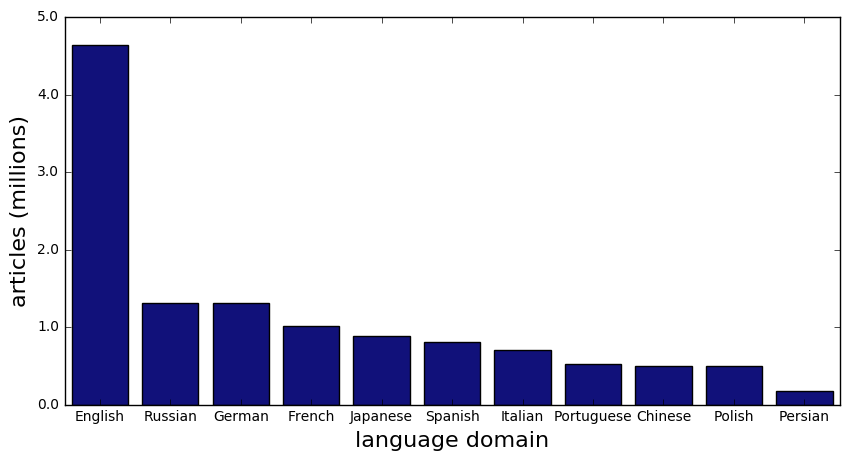

In [16]:
plt.figure(figsize=(10,5))
fig = sns.barplot(y = 'articles_count', x = 'language', 
              data = w2a_graph_sizes_df[['language', 'articles_count']], 
              color = 'darkblue')
plt.xlabel('language domain', fontsize=16)
plt.ylabel('articles (millions)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.yticks(fig.get_yticks(), fig.get_yticks()/1000000);

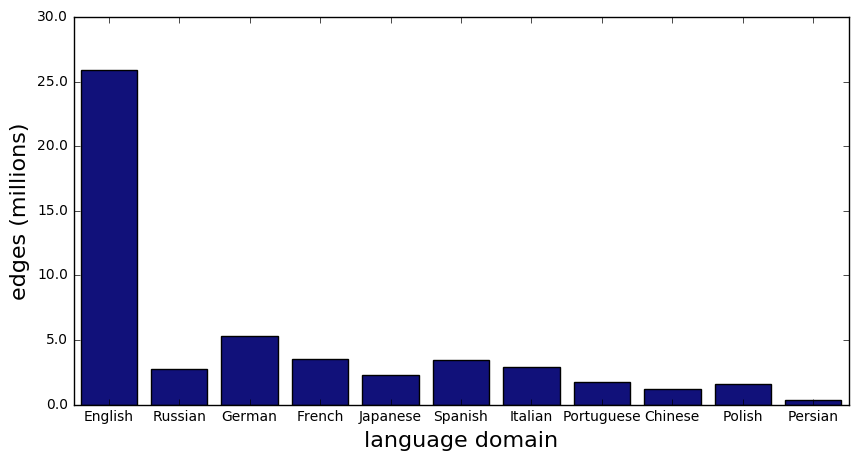

In [17]:
plt.figure(figsize=(10,5))
fig = sns.barplot(y = 'edges_count', x = 'language', 
              data = w2a_graph_sizes_df[['language', 'edges_count']], 
              color = 'darkblue')
plt.xlabel('language domain', fontsize=16)
plt.ylabel('edges (millions)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.yticks(fig.get_yticks(), fig.get_yticks()/1000000);

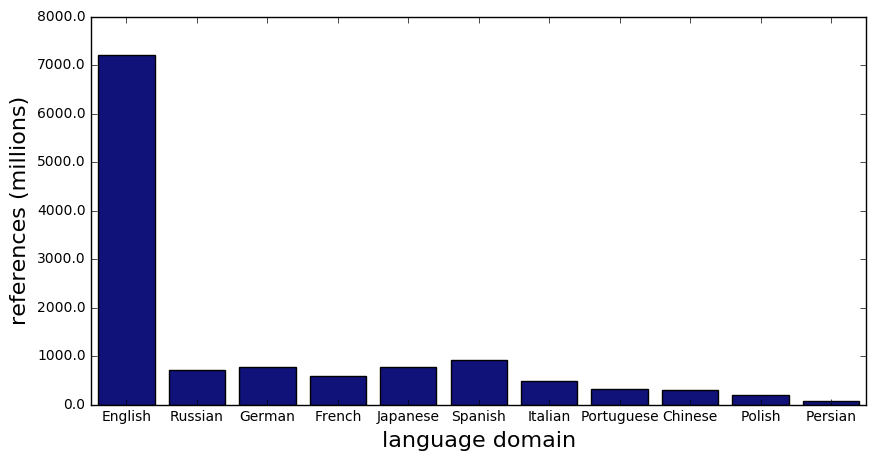

In [15]:
plt.figure(figsize=(10,5))
fig = sns.barplot(y = 'references_count', x = 'language', 
              data = w2a_graph_sizes_df[['language', 'references_count']], 
              color = 'darkblue')
plt.xlabel('language domain', fontsize=16)
plt.ylabel('references (millions)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.yticks(fig.get_yticks(), fig.get_yticks()/1000000);

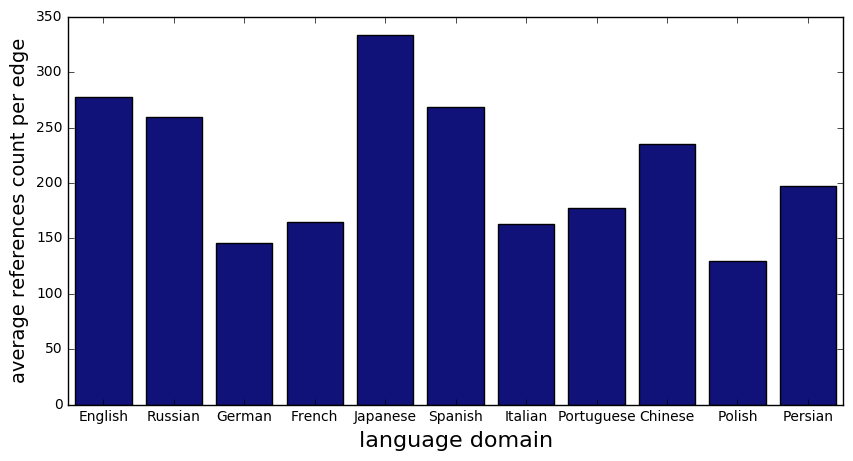

In [110]:
plt.figure(figsize=(10,5))
sns.barplot(y = 'refs_per_edge_avg', x = 'language', 
              data = w2a_graph_sizes_df[['language', 'refs_per_edge_avg']], 
              color = 'darkblue')
plt.xlabel('language domain', fontsize=16)
plt.ylabel('average references count per edge', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

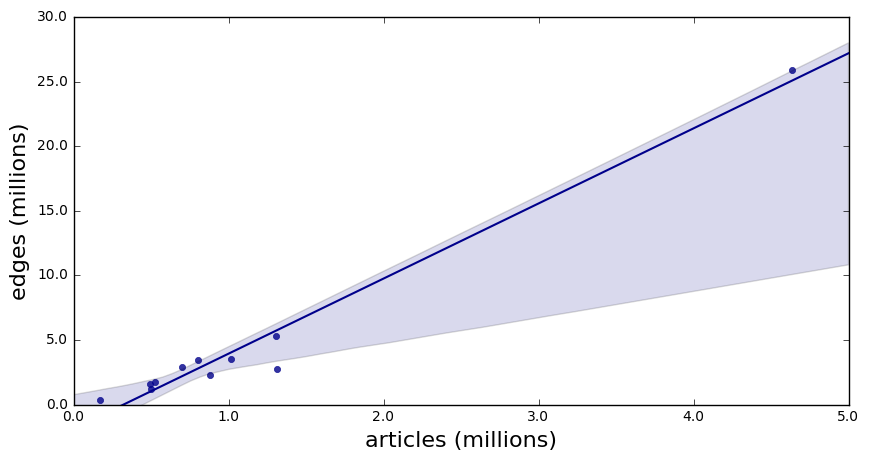

In [18]:
plt.figure(figsize=(10,5))
fig = sns.regplot(y = 'edges_count', x = 'articles_count', 
              data = w2a_graph_sizes_df[['articles_count', 'edges_count']], 
              color = 'darkblue')

plt.xlim(0, None)
plt.ylim(0, None)

plt.xlabel('articles (millions)', fontsize=16)
plt.ylabel('edges (millions)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(fig.get_xticks(), fig.get_xticks()/1000000)
plt.yticks(fig.get_yticks(), fig.get_yticks()/1000000);

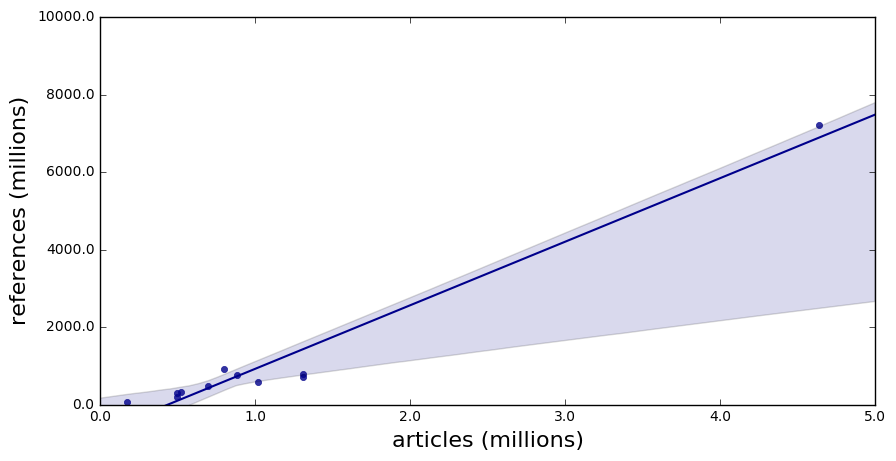

In [19]:
plt.figure(figsize=(10,5))
fig = sns.regplot(y = 'references_count', x = 'articles_count', 
              data = w2a_graph_sizes_df[['articles_count', 'references_count']], 
              color = 'darkblue')

plt.xlim(0, None)
plt.ylim(0, None)

plt.xlabel('articles (millions)', fontsize=16)
plt.ylabel('references (millions)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(fig.get_xticks(), fig.get_xticks()/1000000)
plt.yticks(fig.get_yticks(), fig.get_yticks()/1000000);

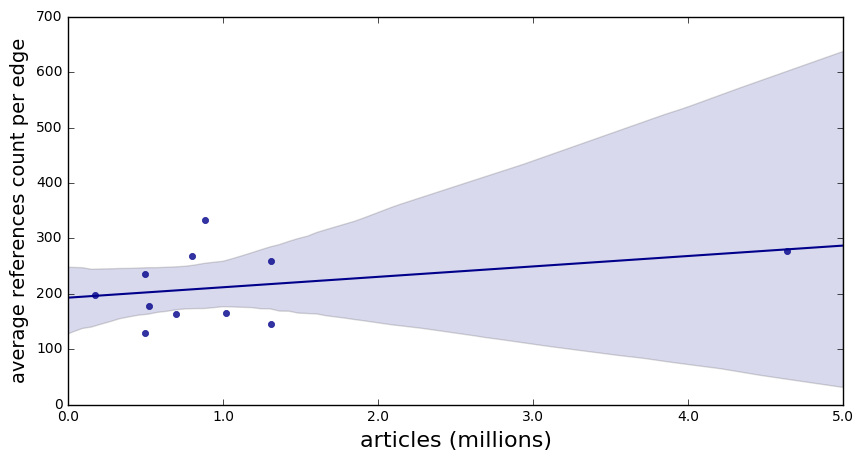

In [20]:
plt.figure(figsize=(10,5))
fig = sns.regplot(y = 'refs_per_edge_avg', x = 'articles_count', 
              data = w2a_graph_sizes_df[['articles_count', 'refs_per_edge_avg']], 
              color = 'darkblue')

plt.xlim(0, None)
plt.ylim(0, None)

plt.xlabel('articles (millions)', fontsize=16)
plt.ylabel('average references count per edge', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(fig.get_xticks(), fig.get_xticks()/1000000);

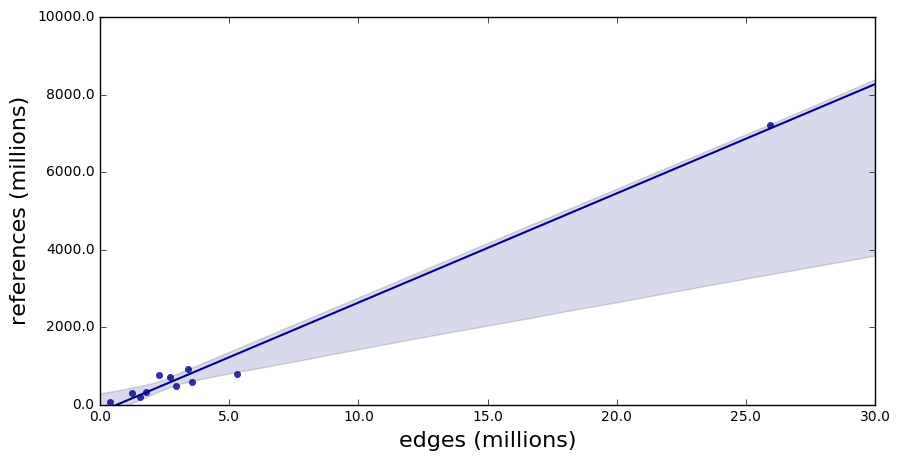

In [21]:
plt.figure(figsize=(10,5))
fig = sns.regplot(y = 'references_count', x = 'edges_count', 
              data = w2a_graph_sizes_df[['references_count', 'edges_count']], 
              color = 'darkblue')

plt.xlim(0, None)
plt.ylim(0, None)

plt.xlabel('edges (millions)', fontsize=16)
plt.ylabel('references (millions)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(fig.get_xticks(), fig.get_xticks()/1000000)
plt.yticks(fig.get_yticks(), fig.get_yticks()/1000000);

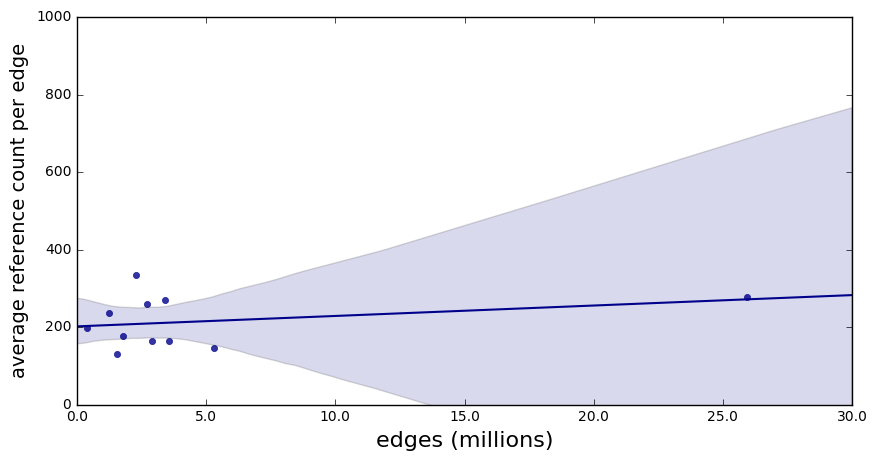

In [24]:
plt.figure(figsize=(10,5))
fig = sns.regplot(y = 'refs_per_edge_avg', x = 'edges_count', 
              data = w2a_graph_sizes_df[['refs_per_edge_avg', 'edges_count']], 
              color = 'darkblue')

plt.xlim(0, None)
plt.ylim(0, None)

plt.xlabel('edges (millions)', fontsize=16)
plt.ylabel('average reference count per edge', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(fig.get_xticks(), fig.get_xticks()/1000000);

#### Network density

Network density is a ratio of how many relationships there are in a graph relative to all possible relationships of that graph. In an undirected simple graph, there are N(N-1) possible relationships, where N is the number of nodes in the graph. Network density values range from 0 to 1, with 1 being a fully connected graph, and values close to 0 indicating that the graph is very sparse.

In [24]:
# Density of the English domain Wikipedia clickstream graph (based on undirected edges)
round(25917378 * 1.0 /( (4636312 + 5) * (4636312 + 5 - 1) ), 6)

1e-06

In [7]:
# The number of all possible undirected edges in the English domain Wikipedia clickstream graph
(4636312 + 5) * (4636312 + 5 - 1)

21495430688172

In [7]:
w2a_graph_density_df = w2a_graph_sizes_df[['language', 'language_code', 'articles_count', 'external_sources_count', \
       'edges_count']]

w2a_graph_density_df['all_possible_edges'] = \
    (w2a_graph_density_df['articles_count'] + w2a_graph_density_df['external_sources_count']) * \
    (w2a_graph_density_df['articles_count'] + w2a_graph_density_df['external_sources_count'] - 1)

w2a_graph_density_df['density'] = w2a_graph_density_df['edges_count'] * 1.0/w2a_graph_density_df['all_possible_edges']

w2a_graph_density_df

,language,language_code,articles_count,external_sources_count,edges_count,all_possible_edges,density
9,English,EN,4636312,5,25917378,21495430688172,0.000001
1,Russian,RU,1310230,5,2712051,1716714444990,0.000002
0,German,DE,1307048,5,5305000,1708386237756,0.000003
3,French,FR,1018507,5,3545691,1037365675632,0.000003
10,Japanese,JA,880747,5,2295941,775723204752,0.000003
7,Spanish,ES,802360,5,3409055,643788790860,0.000005
5,Italian,IT,698313,5,2919343,487647330806,0.000006
6,Portuguese,PT,523616,5,1773920,274178428020,0.000006
4,Chinese,ZH,497074,5,1238296,247087035162,0.000005
8,Polish,PL,493158,5,1556704,243209251406,0.000006


In [9]:
# Average centrality metrics

w2a_graph_centrality_df = w2a_graph_sizes_df[['language', 'language_code', 'articles_count', 'external_sources_count', \
       'edges_count', 'references_count']]

# average degree
w2a_graph_centrality_df['degree_avg'] = w2a_graph_centrality_df['edges_count'] * \
    1.0/(w2a_graph_centrality_df['articles_count'] + w2a_graph_centrality_df['external_sources_count'])

# average weighted degree
w2a_graph_centrality_df['weighted_degree_avg'] = w2a_graph_centrality_df['references_count'] * \
    1.0/(w2a_graph_centrality_df['articles_count'] + w2a_graph_centrality_df['external_sources_count'])

w2a_graph_centrality_df    

,language,language_code,articles_count,external_sources_count,edges_count,references_count,degree_avg,weighted_degree_avg
9,English,EN,4636312,5,25917378,7209691324,5.590079,1555.047104
1,Russian,RU,1310230,5,2712051,704827086,2.069897,537.939443
0,German,DE,1307048,5,5305000,775318583,4.058749,593.180677
3,French,FR,1018507,5,3545691,584620558,3.481246,573.994767
10,Japanese,JA,880747,5,2295941,765429220,2.606796,869.063278
7,Spanish,ES,802360,5,3409055,915554698,4.248758,1141.070084
5,Italian,IT,698313,5,2919343,476970761,4.180535,683.028020
6,Portuguese,PT,523616,5,1773920,315514276,3.387794,602.562304
4,Chinese,ZH,497074,5,1238296,291813076,2.491145,587.055732
8,Polish,PL,493158,5,1556704,202264461,3.156571,410.137137


#### Nodes with highest degree

In [ ]:
# cypher queries for neo4j browser, to get a visualization

# top 10 nodes by out-degree
MATCH (n {language_code:'FA'})
RETURN n,size((n)-->()) as degree 
ORDER BY degree DESC LIMIT 10

# top 10 nodes by weighted out-degree
MATCH (n {language_code:'PL'})-[r:REFERRED_TO]->()
RETURN n,sum(toInteger(r.count)) as weighted_degree 
ORDER BY weighted_degree DESC LIMIT 10

In [37]:
test0 = graph.data("""
MATCH (n {language_code:'FA'})
RETURN labels(n) as node_label, properties(n) as node, size((n)-->()) as degree 
ORDER BY degree DESC LIMIT 10
""")
test0

[{'degree': 143195,
  'node': {'description': 'an external search engine',
   'language': 'Persian',
   'language_code': 'FA',
   'source_type': 'other-search'},
  'node_label': ['ExternalSource']},
 {'degree': 132448,
  'node': {'description': 'an empty referer',
   'language': 'Persian',
   'language_code': 'FA',
   'source_type': 'other-empty'},
  'node_label': ['ExternalSource']},
 {'degree': 47021,
  'node': {'description': 'a page from any other Wikimedia project (not Wikipedia)',
   'language': 'Persian',
   'language_code': 'FA',
   'source_type': 'other-internal'},
  'node_label': ['ExternalSource']},
 {'degree': 43412,
  'node': {'description': 'anything else (catch-all)',
   'language': 'Persian',
   'language_code': 'FA',
   'source_type': 'other-other'},
  'node_label': ['ExternalSource']},
 {'degree': 9408,
  'node': {'description': 'any other external site (not search engine)',
   'language': 'Persian',
   'language_code': 'FA',
   'source_type': 'other-external'},
  'no

In [35]:
test0[0]['degree']

143195

In [36]:
test0[0]['node']['description']

'an external search engine'

In [39]:
test0[0]['node_label'][0]

'ExternalSource'

In [40]:
pd.DataFrame(test0)

,degree,node,node_label
0,143195,"{'source_type': 'other-search', 'language': 'P...",[ExternalSource]
1,132448,"{'source_type': 'other-empty', 'language': 'Pe...",[ExternalSource]
2,47021,"{'source_type': 'other-internal', 'language': ...",[ExternalSource]
3,43412,"{'source_type': 'other-other', 'language': 'Pe...",[ExternalSource]
4,9408,"{'source_type': 'other-external', 'language': ...",[ExternalSource]
5,14,"{'language': 'Persian', 'language_code': 'FA',...",[Article]
6,6,"{'language': 'Persian', 'language_code': 'FA',...",[Article]
7,5,"{'language': 'Persian', 'language_code': 'FA',...",[Article]
8,2,"{'language': 'Persian', 'language_code': 'FA',...",[Article]
9,2,"{'language': 'Persian', 'language_code': 'FA',...",[Article]


In [43]:
# 'edge_direction' values: 'in', 'out', 'both' (default)
# 'weighted' values: 'n', 'y' (default)
def highest_degree_nodes(language_code, num_to_return, edge_direction, weighted):
    if edge_direction == 'out':
        if weighted == 'n':
            wt = ""
            highest_deg_nodes = graph.data("""
                MATCH (n {language_code: {lang_code} })
                RETURN labels(n) as node_labels, properties(n) as node, size((n)-->()) as degree 
                ORDER BY degree DESC LIMIT {num}
                """, lang_code = language_code, num = num_to_return)
        else:
            wt = "weighted"
            highest_deg_nodes = graph.data("""
                MATCH (n {language_code: {lang_code} })-[r:REFERRED_TO]->()
                RETURN labels(n) as node_labels, properties(n) as node, sum(toInteger(r.count)) as weighted_degree 
                ORDER BY weighted_degree DESC LIMIT {num}
                """, lang_code = language_code, num = num_to_return)
    elif edge_direction == 'in':
        if weighted == 'n':
            wt = ""
            highest_deg_nodes = graph.data("""
                MATCH (n {language_code: {lang_code} })
                RETURN labels(n) as node_labels, properties(n) as node, size(()-->(n)) as degree 
                ORDER BY degree DESC LIMIT {num}
                """, lang_code = language_code, num = num_to_return)
        else:
            wt = "weighted"
            highest_deg_nodes = graph.data("""
                MATCH ()-[r:REFERRED_TO]->(n {language_code: {lang_code} })
                RETURN labels(n) as node_labels, properties(n) as node, sum(toInteger(r.count)) as weighted_degree 
                ORDER BY weighted_degree DESC LIMIT {num}
                """, lang_code = language_code, num = num_to_return)
    else:
        # edge direction doesn't matter
        if weighted == 'n':
            wt = ""
            highest_deg_nodes = graph.data("""
                MATCH (n {language_code: {lang_code} })
                RETURN labels(n) as node_labels, properties(n) as node, size(()--(n)) as degree 
                ORDER BY degree DESC LIMIT {num}
                """, lang_code = language_code, num = num_to_return)
        else:
            wt = "weighted"
            highest_deg_nodes = graph.data("""
                MATCH ()-[r:REFERRED_TO]-(n {language_code: {lang_code} })
                RETURN labels(n) as node_labels, properties(n) as node, sum(toInteger(r.count)) as weighted_degree 
                ORDER BY weighted_degree DESC LIMIT {num}
                """, lang_code = language_code, num = num_to_return)
    
    
    
    # pickle the result
    myoutfile = "pickles/top" + str(num_to_return) + "_" + wt + "_" + edge_direction + "_deg_" + language_code + ".pkl"
    with open(myoutfile, 'wb') as picklefile:
        pickle.dump(highest_deg_nodes, picklefile)

    print("Pickle created: " + myoutfile)
    

In [53]:
num = 10
for lang in list(lang_dict.keys()):
    print("===== Getting high deg nodes for " + lang + " ======")
    for edge_dir in ['in', 'out', 'both']:
        for wtd in ['n', 'y']:
            # get highest deg nodes and pickle them
            highest_degree_nodes(lang, num, edge_dir, wtd)
    
    print("======= Finished " + lang + " ==========\n\n")

===== Getting high deg nodes for PT ======
Pickle created: pickles/top10__in_deg_PT.pkl
Pickle created: pickles/top10_weighted_in_deg_PT.pkl
Pickle created: pickles/top10__out_deg_PT.pkl
Pickle created: pickles/top10_weighted_out_deg_PT.pkl
Pickle created: pickles/top10__both_deg_PT.pkl
Pickle created: pickles/top10_weighted_both_deg_PT.pkl
======= Finished PT ==========


===== Getting high deg nodes for IT ======
Pickle created: pickles/top10__in_deg_IT.pkl
Pickle created: pickles/top10_weighted_in_deg_IT.pkl
Pickle created: pickles/top10__out_deg_IT.pkl
Pickle created: pickles/top10_weighted_out_deg_IT.pkl
Pickle created: pickles/top10__both_deg_IT.pkl
Pickle created: pickles/top10_weighted_both_deg_IT.pkl
======= Finished IT ==========


===== Getting high deg nodes for RU ======
Pickle created: pickles/top10__in_deg_RU.pkl
Pickle created: pickles/top10_weighted_in_deg_RU.pkl
Pickle created: pickles/top10__out_deg_RU.pkl
Pickle created: pickles/top10_weighted_out_deg_RU.pkl
Pickle 

In [54]:
!ls pickles

top10__both_deg_DE.pkl		top10_weighted_both_deg_EN.pkl
top10__both_deg_EN.pkl		top10_weighted_both_deg_ES.pkl
top10__both_deg_ES.pkl		top10_weighted_both_deg_FA.pkl
top10__both_deg_FA.pkl		top10_weighted_both_deg_FR.pkl
top10__both_deg_FR.pkl		top10_weighted_both_deg_IT.pkl
top10__both_deg_IT.pkl		top10_weighted_both_deg_JA.pkl
top10__both_deg_JA.pkl		top10_weighted_both_deg_PL.pkl
top10__both_deg_PL.pkl		top10_weighted_both_deg_PT.pkl
top10__both_deg_PT.pkl		top10_weighted_both_deg_RU.pkl
top10__both_deg_RU.pkl		top10_weighted_both_deg_ZH.pkl
top10__both_deg_ZH.pkl		top10_weighted_in_deg_DE.pkl
top10__in_deg_DE.pkl		top10_weighted_in_deg_EN.pkl
top10__in_deg_EN.pkl		top10_weighted_in_deg_ES.pkl
top10__in_deg_ES.pkl		top10_weighted_in_deg_FA.pkl
top10__in_deg_FA.pkl		top10_weighted_in_deg_FR.pkl
top10__in_deg_FR.pkl		top10_weighted_in_deg_IT.pkl
top10__in_deg_IT.pkl		top10_weighted_in_deg_JA.pkl
top10__in_deg_JA.pkl		top10_weighted_in_deg_PL.pkl
top10__in_deg_PL.pkl		top10_weighted_in_

In [20]:
# unpickle
with open("pickles/top10__out_deg_ZH.pkl", 'rb') as picklefile: 
    top10__out_deg_ZH = pickle.load(picklefile)

top10__out_deg_ZH

[{'degree': 448919,
  'node': {'description': 'an empty referer',
   'language': 'Chinese',
   'language_code': 'ZH',
   'source_type': 'other-empty'},
  'node_labels': ['ExternalSource']},
 {'degree': 355008,
  'node': {'description': 'a page from any other Wikimedia project (not Wikipedia)',
   'language': 'Chinese',
   'language_code': 'ZH',
   'source_type': 'other-internal'},
  'node_labels': ['ExternalSource']},
 {'degree': 313170,
  'node': {'description': 'an external search engine',
   'language': 'Chinese',
   'language_code': 'ZH',
   'source_type': 'other-search'},
  'node_labels': ['ExternalSource']},
 {'degree': 66602,
  'node': {'description': 'anything else (catch-all)',
   'language': 'Chinese',
   'language_code': 'ZH',
   'source_type': 'other-other'},
  'node_labels': ['ExternalSource']},
 {'degree': 29495,
  'node': {'description': 'any other external site (not search engine)',
   'language': 'Chinese',
   'language_code': 'ZH',
   'source_type': 'other-external'},

In [56]:
# unpickle
with open("pickles/top10_weighted_out_deg_ZH.pkl", 'rb') as picklefile: 
    top10_weighted_out_deg_ZH = pickle.load(picklefile)

top10_weighted_out_deg_ZH

[{'node': {'description': 'an external search engine',
   'language': 'Chinese',
   'language_code': 'ZH',
   'source_type': 'other-search'},
  'node_labels': ['ExternalSource'],
  'weighted_degree': 137232589},
 {'node': {'description': 'a page from any other Wikimedia project (not Wikipedia)',
   'language': 'Chinese',
   'language_code': 'ZH',
   'source_type': 'other-internal'},
  'node_labels': ['ExternalSource'],
  'weighted_degree': 79075900},
 {'node': {'description': 'an empty referer',
   'language': 'Chinese',
   'language_code': 'ZH',
   'source_type': 'other-empty'},
  'node_labels': ['ExternalSource'],
  'weighted_degree': 67945380},
 {'node': {'description': 'anything else (catch-all)',
   'language': 'Chinese',
   'language_code': 'ZH',
   'source_type': 'other-other'},
  'node_labels': ['ExternalSource'],
  'weighted_degree': 4409067},
 {'node': {'description': 'any other external site (not search engine)',
   'language': 'Chinese',
   'language_code': 'ZH',
   'source

In [27]:
test['node'][0]['language']

'Chinese'

In [44]:
top10__out_deg_ZH_2 = []
for item in top10__out_deg_ZH:
    newdict = {}
    newdict['degree'] = item['degree']
    newdict['node_label'] = item['node_labels'][0]
    newdict['language'] = item['node']['language']
    newdict['language_code'] = item['node']['language_code']
    
    if 'title' in item['node'].keys():
        newdict['title'] = item['node']['title']
        newdict['link'] = 'https://' + newdict['language_code'].lower() + '.wikipedia.org/wiki/' + newdict['title'] 
        newdict['description'] = ''
    else:
        newdict['title'] = ''
        newdict['link'] = ''
        newdict['description'] = item['node']['description']
        
    top10__out_deg_ZH_2.append(newdict)

#top10__out_deg_ZH_2

In [46]:
top10__out_deg_ZH_2_df = pd.DataFrame(top10__out_deg_ZH_2)

# reorder columns
top10__out_deg_ZH_2_df = top10__out_deg_ZH_2_df[['language', 'language_code', 'node_label', 'degree', \
                                         'description', 'title', 'link']]
top10__out_deg_ZH_2_df

,language,language_code,node_label,degree,description,title,link
0,Chinese,ZH,ExternalSource,448919,an empty referer,,
1,Chinese,ZH,ExternalSource,355008,a page from any other Wikimedia project (not W...,,
2,Chinese,ZH,ExternalSource,313170,an external search engine,,
3,Chinese,ZH,ExternalSource,66602,anything else (catch-all),,
4,Chinese,ZH,ExternalSource,29495,any other external site (not search engine),,
5,Chinese,ZH,Article,465,,Wiki,https://zh.wikipedia.org/wiki/Wiki
6,Chinese,ZH,Article,163,,POP_TEAM_EPIC,https://zh.wikipedia.org/wiki/POP_TEAM_EPIC
7,Chinese,ZH,Article,159,,Node.js,https://zh.wikipedia.org/wiki/Node.js
8,Chinese,ZH,Article,104,,Running_Man,https://zh.wikipedia.org/wiki/Running_Man
9,Chinese,ZH,Article,100,,NBA,https://zh.wikipedia.org/wiki/NBA


In [59]:
# unpickle and make the top10 output into a dataframe
# (picklename is without extension)
def df_top10(picklename):
    # unpickle
    fullpath = "pickles/" + picklename + ".pkl"
    with open(fullpath, 'rb') as picklefile: 
        list_of_dicts_mess = pickle.load(picklefile)
        
    # reorganize the list of dictionaries
    list_of_dicts_notmess = []
    for item in list_of_dicts_mess:
        newdict = {}
        
        if 'degree' in item.keys():
            newdict['degree'] = item['degree']
        else:
            newdict['weighted_degree'] = item['weighted_degree']
        
        newdict['node_label'] = item['node_labels'][0]
        newdict['language'] = item['node']['language']
        newdict['language_code'] = item['node']['language_code']

        if 'title' in item['node'].keys():
            newdict['title'] = item['node']['title']
            newdict['link'] = 'https://' + newdict['language_code'].lower() + '.wikipedia.org/wiki/' + newdict['title'] 
            newdict['description'] = ''
        else:
            newdict['title'] = ''
            newdict['link'] = ''
            newdict['description'] = item['node']['description']

        list_of_dicts_notmess.append(newdict)

    
    # into df!
    top10_df = pd.DataFrame(list_of_dicts_notmess)

    # reorder columns
    if 'degree' in top10_df.columns:
        top10_df = top10_df[['language', 'language_code', 'node_label', 'degree', 'description', 'title', 'link']]
    else:
        top10_df = top10_df[['language', 'language_code', 'node_label', 'weighted_degree', 'description', 'title', 'link']]
    
    return top10_df


In [60]:
df_top10('top10_weighted_in_deg_ZH')

,language,language_code,node_label,weighted_degree,description,title,link
0,Chinese,ZH,Article,1179139,,連字暨減號,https://zh.wikipedia.org/wiki/連字暨減號
1,Chinese,ZH,Article,789892,,郭建宏_(製作人),https://zh.wikipedia.org/wiki/郭建宏_(製作人)
2,Chinese,ZH,Article,707887,,史蒂芬·霍金,https://zh.wikipedia.org/wiki/史蒂芬·霍金
3,Chinese,ZH,Article,576862,,烈火如歌,https://zh.wikipedia.org/wiki/烈火如歌
4,Chinese,ZH,Article,415903,,金家好媳婦,https://zh.wikipedia.org/wiki/金家好媳婦
5,Chinese,ZH,Article,367538,,习近平,https://zh.wikipedia.org/wiki/习近平
6,Chinese,ZH,Article,332378,,姊的時代,https://zh.wikipedia.org/wiki/姊的時代
7,Chinese,ZH,Article,324867,,和遊記,https://zh.wikipedia.org/wiki/和遊記
8,Chinese,ZH,Article,321816,,老男孩_(电视剧),https://zh.wikipedia.org/wiki/老男孩_(电视剧)
9,Chinese,ZH,Article,320582,,李敖,https://zh.wikipedia.org/wiki/李敖


In [61]:
# display the top10s

for lang in list(lang_dict.keys()):
    print("===== Top 10 high deg nodes for " + lang + " ======")
    for edge_dir in ['in', 'out', 'both']:
        print("------- Edge direction: " + edge_dir + " -------")
        for wtd in ['n', 'y']:
            print("--- Weighted: " + wtd + " ---")
            
            # put together picklename
            if wtd == 'n':
                wt = ''
            else:
                wt = 'weighted'
                
            mypickle = "top10_" + wt + "_" + edge_dir + "_deg_" + lang
            
            print(mypickle)
            
            # unpickle, make df and display it
            display(df_top10(mypickle))
    
    print("======= Finished " + lang + " ==========\n\n")
    

===== Top 10 high deg nodes for ZH ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_ZH


,language,language_code,node_label,degree,description,title,link
0,Chinese,ZH,Article,79,,連字暨減號,https://zh.wikipedia.org/wiki/連字暨減號
1,Chinese,ZH,Article,42,,TWICE,https://zh.wikipedia.org/wiki/TWICE
2,Chinese,ZH,Article,40,,Red_Velvet,https://zh.wikipedia.org/wiki/Red_Velvet
3,Chinese,ZH,Article,39,,Alexa_Internet,https://zh.wikipedia.org/wiki/Alexa_Internet
4,Chinese,ZH,Article,38,,The_Unit,https://zh.wikipedia.org/wiki/The_Unit
5,Chinese,ZH,Article,37,,GFRIEND,https://zh.wikipedia.org/wiki/GFRIEND
6,Chinese,ZH,Article,37,,LOEN娛樂,https://zh.wikipedia.org/wiki/LOEN娛樂
7,Chinese,ZH,Article,35,,EXO,https://zh.wikipedia.org/wiki/EXO
8,Chinese,ZH,Article,34,,GOT7,https://zh.wikipedia.org/wiki/GOT7
9,Chinese,ZH,Article,34,,SM娛樂,https://zh.wikipedia.org/wiki/SM娛樂


--- Weighted: y ---
top10_weighted_in_deg_ZH


,language,language_code,node_label,weighted_degree,description,title,link
0,Chinese,ZH,Article,1179139,,連字暨減號,https://zh.wikipedia.org/wiki/連字暨減號
1,Chinese,ZH,Article,789892,,郭建宏_(製作人),https://zh.wikipedia.org/wiki/郭建宏_(製作人)
2,Chinese,ZH,Article,707887,,史蒂芬·霍金,https://zh.wikipedia.org/wiki/史蒂芬·霍金
3,Chinese,ZH,Article,576862,,烈火如歌,https://zh.wikipedia.org/wiki/烈火如歌
4,Chinese,ZH,Article,415903,,金家好媳婦,https://zh.wikipedia.org/wiki/金家好媳婦
5,Chinese,ZH,Article,367538,,习近平,https://zh.wikipedia.org/wiki/习近平
6,Chinese,ZH,Article,332378,,姊的時代,https://zh.wikipedia.org/wiki/姊的時代
7,Chinese,ZH,Article,324867,,和遊記,https://zh.wikipedia.org/wiki/和遊記
8,Chinese,ZH,Article,321816,,老男孩_(电视剧),https://zh.wikipedia.org/wiki/老男孩_(电视剧)
9,Chinese,ZH,Article,320582,,李敖,https://zh.wikipedia.org/wiki/李敖


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_ZH


,language,language_code,node_label,degree,description,title,link
0,Chinese,ZH,ExternalSource,448919,an empty referer,,
1,Chinese,ZH,ExternalSource,355008,a page from any other Wikimedia project (not W...,,
2,Chinese,ZH,ExternalSource,313170,an external search engine,,
3,Chinese,ZH,ExternalSource,66602,anything else (catch-all),,
4,Chinese,ZH,ExternalSource,29495,any other external site (not search engine),,
5,Chinese,ZH,Article,465,,Wiki,https://zh.wikipedia.org/wiki/Wiki
6,Chinese,ZH,Article,163,,POP_TEAM_EPIC,https://zh.wikipedia.org/wiki/POP_TEAM_EPIC
7,Chinese,ZH,Article,159,,Node.js,https://zh.wikipedia.org/wiki/Node.js
8,Chinese,ZH,Article,104,,Running_Man,https://zh.wikipedia.org/wiki/Running_Man
9,Chinese,ZH,Article,100,,NBA,https://zh.wikipedia.org/wiki/NBA


--- Weighted: y ---
top10_weighted_out_deg_ZH


,language,language_code,node_label,weighted_degree,description,title,link
0,Chinese,ZH,ExternalSource,137232589,an external search engine,,
1,Chinese,ZH,ExternalSource,79075900,a page from any other Wikimedia project (not W...,,
2,Chinese,ZH,ExternalSource,67945380,an empty referer,,
3,Chinese,ZH,ExternalSource,4409067,anything else (catch-all),,
4,Chinese,ZH,ExternalSource,1455784,any other external site (not search engine),,
5,Chinese,ZH,Article,49967,,Wanna_One,https://zh.wikipedia.org/wiki/Wanna_One
6,Chinese,ZH,Article,44884,,Radio_Romance,https://zh.wikipedia.org/wiki/Radio_Romance
7,Chinese,ZH,Article,43283,,Running_Man,https://zh.wikipedia.org/wiki/Running_Man
8,Chinese,ZH,Article,34993,,TWICE,https://zh.wikipedia.org/wiki/TWICE
9,Chinese,ZH,Article,28660,,HIStory2,https://zh.wikipedia.org/wiki/HIStory2


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_ZH


,language,language_code,node_label,degree,description,title,link
0,Chinese,ZH,ExternalSource,448919,an empty referer,,
1,Chinese,ZH,ExternalSource,355008,a page from any other Wikimedia project (not W...,,
2,Chinese,ZH,ExternalSource,313170,an external search engine,,
3,Chinese,ZH,ExternalSource,66602,anything else (catch-all),,
4,Chinese,ZH,ExternalSource,29495,any other external site (not search engine),,
5,Chinese,ZH,Article,472,,Wiki,https://zh.wikipedia.org/wiki/Wiki
6,Chinese,ZH,Article,170,,POP_TEAM_EPIC,https://zh.wikipedia.org/wiki/POP_TEAM_EPIC
7,Chinese,ZH,Article,167,,Node.js,https://zh.wikipedia.org/wiki/Node.js
8,Chinese,ZH,Article,142,,TWICE,https://zh.wikipedia.org/wiki/TWICE
9,Chinese,ZH,Article,138,,The_Unit,https://zh.wikipedia.org/wiki/The_Unit


--- Weighted: y ---
top10_weighted_both_deg_ZH


,language,language_code,node_label,weighted_degree,description,title,link
0,Chinese,ZH,ExternalSource,137232589,an external search engine,,
1,Chinese,ZH,ExternalSource,79075900,a page from any other Wikimedia project (not W...,,
2,Chinese,ZH,ExternalSource,67945380,an empty referer,,
3,Chinese,ZH,ExternalSource,4409067,anything else (catch-all),,
4,Chinese,ZH,ExternalSource,1455784,any other external site (not search engine),,
5,Chinese,ZH,Article,1179139,,連字暨減號,https://zh.wikipedia.org/wiki/連字暨減號
6,Chinese,ZH,Article,789892,,郭建宏_(製作人),https://zh.wikipedia.org/wiki/郭建宏_(製作人)
7,Chinese,ZH,Article,707887,,史蒂芬·霍金,https://zh.wikipedia.org/wiki/史蒂芬·霍金
8,Chinese,ZH,Article,576862,,烈火如歌,https://zh.wikipedia.org/wiki/烈火如歌
9,Chinese,ZH,Article,415903,,金家好媳婦,https://zh.wikipedia.org/wiki/金家好媳婦


======= Finished ZH ==========


===== Top 10 high deg nodes for FA ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_FA


,language,language_code,node_label,degree,description,title,link
0,Persian,FA,Article,6,,هوش_هیجانی,https://fa.wikipedia.org/wiki/هوش_هیجانی
1,Persian,FA,Article,6,,مهندسی_پزشکی,https://fa.wikipedia.org/wiki/مهندسی_پزشکی
2,Persian,FA,Article,6,,فناوری_اطلاعات,https://fa.wikipedia.org/wiki/فناوری_اطلاعات
3,Persian,FA,Article,6,,اتومبیل‌دزدی_بزرگ_۵,https://fa.wikipedia.org/wiki/اتومبیل‌دزدی_بزرگ_۵
4,Persian,FA,Article,6,,آدنوزین_تری‌فسفات,https://fa.wikipedia.org/wiki/آدنوزین_تری‌فسفات
5,Persian,FA,Article,6,,اوکی,https://fa.wikipedia.org/wiki/اوکی
6,Persian,FA,Article,6,,سکس_(فیلم),https://fa.wikipedia.org/wiki/سکس_(فیلم)
7,Persian,FA,Article,6,,اره_(مجموعه‌فیلم),https://fa.wikipedia.org/wiki/اره_(مجموعه‌فیلم)
8,Persian,FA,Article,6,,داعش,https://fa.wikipedia.org/wiki/داعش
9,Persian,FA,Article,6,,دستگاه_بین‌المللی_یکاها,https://fa.wikipedia.org/wiki/دستگاه_بین‌الملل...


--- Weighted: y ---
top10_weighted_in_deg_FA


,language,language_code,node_label,weighted_degree,description,title,link
0,Persian,FA,Article,607456,,صفحهٔ_اصلی,https://fa.wikipedia.org/wiki/صفحهٔ_اصلی
1,Persian,FA,Article,391920,,استیون_هاوکینگ,https://fa.wikipedia.org/wiki/استیون_هاوکینگ
2,Persian,FA,Article,185411,,هفت‌سین,https://fa.wikipedia.org/wiki/هفت‌سین
3,Persian,FA,Article,162451,,سید_صادق_حسینی_شیرازی,https://fa.wikipedia.org/wiki/سید_صادق_حسینی_ش...
4,Persian,FA,Article,137306,,پایتخت_۵,https://fa.wikipedia.org/wiki/پایتخت_۵
5,Persian,FA,Article,132084,,چهارشنبه‌سوری,https://fa.wikipedia.org/wiki/چهارشنبه‌سوری
6,Persian,FA,Article,129360,,آمیزش_جنسی,https://fa.wikipedia.org/wiki/آمیزش_جنسی
7,Persian,FA,Article,120726,,سوفیا_لورن,https://fa.wikipedia.org/wiki/سوفیا_لورن
8,Persian,FA,Article,118229,,کتایون_ریاحی,https://fa.wikipedia.org/wiki/کتایون_ریاحی
9,Persian,FA,Article,106495,,به_وقت_شام,https://fa.wikipedia.org/wiki/به_وقت_شام


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_FA


,language,language_code,node_label,degree,description,title,link
0,Persian,FA,ExternalSource,143195,an external search engine,,
1,Persian,FA,ExternalSource,132448,an empty referer,,
2,Persian,FA,ExternalSource,47021,a page from any other Wikimedia project (not W...,,
3,Persian,FA,ExternalSource,43412,anything else (catch-all),,
4,Persian,FA,ExternalSource,9408,any other external site (not search engine),,
5,Persian,FA,Article,14,,GTA,https://fa.wikipedia.org/wiki/GTA
6,Persian,FA,Article,6,,SEX,https://fa.wikipedia.org/wiki/SEX
7,Persian,FA,Article,5,,.onion,https://fa.wikipedia.org/wiki/.onion
8,Persian,FA,Article,2,,.ir,https://fa.wikipedia.org/wiki/.ir
9,Persian,FA,Article,2,,.xxx,https://fa.wikipedia.org/wiki/.xxx


--- Weighted: y ---
top10_weighted_out_deg_FA


,language,language_code,node_label,weighted_degree,description,title,link
0,Persian,FA,ExternalSource,52390909,an external search engine,,
1,Persian,FA,ExternalSource,15837672,an empty referer,,
2,Persian,FA,ExternalSource,3579169,anything else (catch-all),,
3,Persian,FA,ExternalSource,1885551,a page from any other Wikimedia project (not W...,,
4,Persian,FA,ExternalSource,363078,any other external site (not search engine),,
5,Persian,FA,Article,1030,,SEX,https://fa.wikipedia.org/wiki/SEX
6,Persian,FA,Article,961,,GTA,https://fa.wikipedia.org/wiki/GTA
7,Persian,FA,Article,176,,XXX,https://fa.wikipedia.org/wiki/XXX
8,Persian,FA,Article,93,,.onion,https://fa.wikipedia.org/wiki/.onion
9,Persian,FA,Article,90,,خلیج_فارس,https://fa.wikipedia.org/wiki/خلیج_فارس


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_FA


,language,language_code,node_label,degree,description,title,link
0,Persian,FA,ExternalSource,143195,an external search engine,,
1,Persian,FA,ExternalSource,132448,an empty referer,,
2,Persian,FA,ExternalSource,47021,a page from any other Wikimedia project (not W...,,
3,Persian,FA,ExternalSource,43412,anything else (catch-all),,
4,Persian,FA,ExternalSource,9408,any other external site (not search engine),,
5,Persian,FA,Article,18,,GTA,https://fa.wikipedia.org/wiki/GTA
6,Persian,FA,Article,10,,SEX,https://fa.wikipedia.org/wiki/SEX
7,Persian,FA,Article,8,,.onion,https://fa.wikipedia.org/wiki/.onion
8,Persian,FA,Article,6,,خلیج_فارس,https://fa.wikipedia.org/wiki/خلیج_فارس
9,Persian,FA,Article,6,,LOL,https://fa.wikipedia.org/wiki/LOL


--- Weighted: y ---
top10_weighted_both_deg_FA


,language,language_code,node_label,weighted_degree,description,title,link
0,Persian,FA,ExternalSource,52390909,an external search engine,,
1,Persian,FA,ExternalSource,15837672,an empty referer,,
2,Persian,FA,ExternalSource,3579169,anything else (catch-all),,
3,Persian,FA,ExternalSource,1885551,a page from any other Wikimedia project (not W...,,
4,Persian,FA,Article,607456,,صفحهٔ_اصلی,https://fa.wikipedia.org/wiki/صفحهٔ_اصلی
5,Persian,FA,Article,391920,,استیون_هاوکینگ,https://fa.wikipedia.org/wiki/استیون_هاوکینگ
6,Persian,FA,ExternalSource,363078,any other external site (not search engine),,
7,Persian,FA,Article,185411,,هفت‌سین,https://fa.wikipedia.org/wiki/هفت‌سین
8,Persian,FA,Article,162451,,سید_صادق_حسینی_شیرازی,https://fa.wikipedia.org/wiki/سید_صادق_حسینی_ش...
9,Persian,FA,Article,137306,,پایتخت_۵,https://fa.wikipedia.org/wiki/پایتخت_۵


======= Finished FA ==========


===== Top 10 high deg nodes for PT ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_PT


,language,language_code,node_label,degree,description,title,link
0,Portuguese,PT,Article,9746,,Hífen,https://pt.wikipedia.org/wiki/Hífen
1,Portuguese,PT,Article,853,,Brasil,https://pt.wikipedia.org/wiki/Brasil
2,Portuguese,PT,Article,585,,Estados_Unidos,https://pt.wikipedia.org/wiki/Estados_Unidos
3,Portuguese,PT,Article,265,,Portugal,https://pt.wikipedia.org/wiki/Portugal
4,Portuguese,PT,Article,201,,Rio_de_Janeiro_(cidade),https://pt.wikipedia.org/wiki/Rio_de_Janeiro_(...
5,Portuguese,PT,Article,197,,Reino_Unido,https://pt.wikipedia.org/wiki/Reino_Unido
6,Portuguese,PT,Article,184,,São_Paulo,https://pt.wikipedia.org/wiki/São_Paulo
7,Portuguese,PT,Article,171,,Seleção_Brasileira_de_Futebol,https://pt.wikipedia.org/wiki/Seleção_Brasilei...
8,Portuguese,PT,Article,168,,Óscar,https://pt.wikipedia.org/wiki/Óscar
9,Portuguese,PT,Article,167,,Sport_Club_Corinthians_Paulista,https://pt.wikipedia.org/wiki/Sport_Club_Corin...


--- Weighted: y ---
top10_weighted_in_deg_PT


,language,language_code,node_label,weighted_degree,description,title,link
0,Portuguese,PT,Article,1191315,,Hífen,https://pt.wikipedia.org/wiki/Hífen
1,Portuguese,PT,Article,770404,,Stephen_Hawking,https://pt.wikipedia.org/wiki/Stephen_Hawking
2,Portuguese,PT,Article,670132,,Dia_Internacional_da_Mulher,https://pt.wikipedia.org/wiki/Dia_Internaciona...
3,Portuguese,PT,Article,499980,,La_casa_de_papel,https://pt.wikipedia.org/wiki/La_casa_de_papel
4,Portuguese,PT,Article,464379,,Via_Crúcis,https://pt.wikipedia.org/wiki/Via_Crúcis
5,Portuguese,PT,Article,401024,,Marielle_Franco,https://pt.wikipedia.org/wiki/Marielle_Franco
6,Portuguese,PT,Article,247463,,Cristiano_Ronaldo,https://pt.wikipedia.org/wiki/Cristiano_Ronaldo
7,Portuguese,PT,Article,222455,,Dia_do_Pi,https://pt.wikipedia.org/wiki/Dia_do_Pi
8,Portuguese,PT,Article,216797,,O_Mecanismo,https://pt.wikipedia.org/wiki/O_Mecanismo
9,Portuguese,PT,Article,186285,,Páscoa,https://pt.wikipedia.org/wiki/Páscoa


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_PT


,language,language_code,node_label,degree,description,title,link
0,Portuguese,PT,ExternalSource,502976,an empty referer,,
1,Portuguese,PT,ExternalSource,387085,an external search engine,,
2,Portuguese,PT,ExternalSource,109393,anything else (catch-all),,
3,Portuguese,PT,ExternalSource,79221,a page from any other Wikimedia project (not W...,,
4,Portuguese,PT,ExternalSource,66616,any other external site (not search engine),,
5,Portuguese,PT,Article,797,,Estados_Unidos,https://pt.wikipedia.org/wiki/Estados_Unidos
6,Portuguese,PT,Article,769,,Brasil,https://pt.wikipedia.org/wiki/Brasil
7,Portuguese,PT,Article,617,,Lista_de_clubes_de_futebol_do_Brasil,https://pt.wikipedia.org/wiki/Lista_de_clubes_...
8,Portuguese,PT,Article,503,,Oscar_de_melhor_filme,https://pt.wikipedia.org/wiki/Oscar_de_melhor_...
9,Portuguese,PT,Article,389,,Portugal,https://pt.wikipedia.org/wiki/Portugal


--- Weighted: y ---
top10_weighted_out_deg_PT


,language,language_code,node_label,weighted_degree,description,title,link
0,Portuguese,PT,ExternalSource,204655119,an external search engine,,
1,Portuguese,PT,ExternalSource,64674744,an empty referer,,
2,Portuguese,PT,ExternalSource,11143319,anything else (catch-all),,
3,Portuguese,PT,ExternalSource,4435416,a page from any other Wikimedia project (not W...,,
4,Portuguese,PT,ExternalSource,2857578,any other external site (not search engine),,
5,Portuguese,PT,Article,132244,,Stephen_Hawking,https://pt.wikipedia.org/wiki/Stephen_Hawking
6,Portuguese,PT,Article,78717,,Dia_Internacional_da_Mulher,https://pt.wikipedia.org/wiki/Dia_Internaciona...
7,Portuguese,PT,Article,71513,,O_Mecanismo,https://pt.wikipedia.org/wiki/O_Mecanismo
8,Portuguese,PT,Article,55114,,La_casa_de_papel,https://pt.wikipedia.org/wiki/La_casa_de_papel
9,Portuguese,PT,Article,52739,,Brasil,https://pt.wikipedia.org/wiki/Brasil


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_PT


,language,language_code,node_label,degree,description,title,link
0,Portuguese,PT,ExternalSource,502976,an empty referer,,
1,Portuguese,PT,ExternalSource,387085,an external search engine,,
2,Portuguese,PT,ExternalSource,109393,anything else (catch-all),,
3,Portuguese,PT,ExternalSource,79221,a page from any other Wikimedia project (not W...,,
4,Portuguese,PT,ExternalSource,66616,any other external site (not search engine),,
5,Portuguese,PT,Article,9746,,Hífen,https://pt.wikipedia.org/wiki/Hífen
6,Portuguese,PT,Article,1622,,Brasil,https://pt.wikipedia.org/wiki/Brasil
7,Portuguese,PT,Article,1382,,Estados_Unidos,https://pt.wikipedia.org/wiki/Estados_Unidos
8,Portuguese,PT,Article,654,,Portugal,https://pt.wikipedia.org/wiki/Portugal
9,Portuguese,PT,Article,632,,Lista_de_clubes_de_futebol_do_Brasil,https://pt.wikipedia.org/wiki/Lista_de_clubes_...


--- Weighted: y ---
top10_weighted_both_deg_PT


,language,language_code,node_label,weighted_degree,description,title,link
0,Portuguese,PT,ExternalSource,204655119,an external search engine,,
1,Portuguese,PT,ExternalSource,64674744,an empty referer,,
2,Portuguese,PT,ExternalSource,11143319,anything else (catch-all),,
3,Portuguese,PT,ExternalSource,4435416,a page from any other Wikimedia project (not W...,,
4,Portuguese,PT,ExternalSource,2857578,any other external site (not search engine),,
5,Portuguese,PT,Article,1191315,,Hífen,https://pt.wikipedia.org/wiki/Hífen
6,Portuguese,PT,Article,902648,,Stephen_Hawking,https://pt.wikipedia.org/wiki/Stephen_Hawking
7,Portuguese,PT,Article,748849,,Dia_Internacional_da_Mulher,https://pt.wikipedia.org/wiki/Dia_Internaciona...
8,Portuguese,PT,Article,555094,,La_casa_de_papel,https://pt.wikipedia.org/wiki/La_casa_de_papel
9,Portuguese,PT,Article,464379,,Via_Crúcis,https://pt.wikipedia.org/wiki/Via_Crúcis


======= Finished PT ==========


===== Top 10 high deg nodes for EN ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_EN


,language,language_code,node_label,degree,description,title,link
0,English,EN,Article,106526,,Hyphen-minus,https://en.wikipedia.org/wiki/Hyphen-minus
1,English,EN,Article,84378,,Main_Page,https://en.wikipedia.org/wiki/Main_Page
2,English,EN,Article,5656,,United_States,https://en.wikipedia.org/wiki/United_States
3,English,EN,Article,3962,,India,https://en.wikipedia.org/wiki/India
4,English,EN,Article,2687,,United_Kingdom,https://en.wikipedia.org/wiki/United_Kingdom
5,English,EN,Article,2305,,World_War_II,https://en.wikipedia.org/wiki/World_War_II
6,English,EN,Article,1997,,China,https://en.wikipedia.org/wiki/China
7,English,EN,Article,1826,,YouTube,https://en.wikipedia.org/wiki/YouTube
8,English,EN,Article,1774,,Academy_Awards,https://en.wikipedia.org/wiki/Academy_Awards
9,English,EN,Article,1756,,Hindi,https://en.wikipedia.org/wiki/Hindi


--- Weighted: y ---
top10_weighted_in_deg_EN


,language,language_code,node_label,weighted_degree,description,title,link
0,English,EN,Article,491751928,,Main_Page,https://en.wikipedia.org/wiki/Main_Page
1,English,EN,Article,73290094,,Hyphen-minus,https://en.wikipedia.org/wiki/Hyphen-minus
2,English,EN,Article,12154245,,Stephen_Hawking,https://en.wikipedia.org/wiki/Stephen_Hawking
3,English,EN,Article,7343776,,XHamster,https://en.wikipedia.org/wiki/XHamster
4,English,EN,Article,4382998,,Black_Panther_(film),https://en.wikipedia.org/wiki/Black_Panther_(f...
5,English,EN,Article,3374022,,Deaths_in_2018,https://en.wikipedia.org/wiki/Deaths_in_2018
6,English,EN,Article,3062400,,The_Shape_of_Water,https://en.wikipedia.org/wiki/The_Shape_of_Water
7,English,EN,Article,3006302,,XXX_(franchise),https://en.wikipedia.org/wiki/XXX_(franchise)
8,English,EN,Article,2731911,,Darth_Vader,https://en.wikipedia.org/wiki/Darth_Vader
9,English,EN,Article,2373633,,Exo_(band),https://en.wikipedia.org/wiki/Exo_(band)


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_EN


,language,language_code,node_label,degree,description,title,link
0,English,EN,ExternalSource,4529325,an empty referer,,
1,English,EN,ExternalSource,3442734,an external search engine,,
2,English,EN,ExternalSource,1134258,a page from any other Wikimedia project (not W...,,
3,English,EN,ExternalSource,986597,any other external site (not search engine),,
4,English,EN,ExternalSource,752393,anything else (catch-all),,
5,English,EN,Article,229863,,Main_Page,https://en.wikipedia.org/wiki/Main_Page
6,English,EN,Article,3889,,Deaths_in_2018,https://en.wikipedia.org/wiki/Deaths_in_2018
7,English,EN,Article,3363,,Wiki,https://en.wikipedia.org/wiki/Wiki
8,English,EN,Article,2417,,Wikipedia,https://en.wikipedia.org/wiki/Wikipedia
9,English,EN,Article,2244,,United_States,https://en.wikipedia.org/wiki/United_States


--- Weighted: y ---
top10_weighted_out_deg_EN


,language,language_code,node_label,weighted_degree,description,title,link
0,English,EN,ExternalSource,3147199007,an external search engine,,
1,English,EN,ExternalSource,2402364716,an empty referer,,
2,English,EN,ExternalSource,174628733,any other external site (not search engine),,
3,English,EN,ExternalSource,118977058,a page from any other Wikimedia project (not W...,,
4,English,EN,ExternalSource,95196486,anything else (catch-all),,
5,English,EN,Article,30203842,,Main_Page,https://en.wikipedia.org/wiki/Main_Page
6,English,EN,Article,2433971,,Stephen_Hawking,https://en.wikipedia.org/wiki/Stephen_Hawking
7,English,EN,Article,1917498,,Black_Panther_(film),https://en.wikipedia.org/wiki/Black_Panther_(f...
8,English,EN,Article,1579167,,90th_Academy_Awards,https://en.wikipedia.org/wiki/90th_Academy_Awards
9,English,EN,Article,1554220,,Deaths_in_2018,https://en.wikipedia.org/wiki/Deaths_in_2018


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_EN


,language,language_code,node_label,degree,description,title,link
0,English,EN,ExternalSource,4529325,an empty referer,,
1,English,EN,ExternalSource,3442734,an external search engine,,
2,English,EN,ExternalSource,1134258,a page from any other Wikimedia project (not W...,,
3,English,EN,ExternalSource,986597,any other external site (not search engine),,
4,English,EN,ExternalSource,752393,anything else (catch-all),,
5,English,EN,Article,314241,,Main_Page,https://en.wikipedia.org/wiki/Main_Page
6,English,EN,Article,106543,,Hyphen-minus,https://en.wikipedia.org/wiki/Hyphen-minus
7,English,EN,Article,7900,,United_States,https://en.wikipedia.org/wiki/United_States
8,English,EN,Article,5267,,India,https://en.wikipedia.org/wiki/India
9,English,EN,Article,4502,,United_Kingdom,https://en.wikipedia.org/wiki/United_Kingdom


--- Weighted: y ---
top10_weighted_both_deg_EN


,language,language_code,node_label,weighted_degree,description,title,link
0,English,EN,ExternalSource,3147199007,an external search engine,,
1,English,EN,ExternalSource,2402364716,an empty referer,,
2,English,EN,Article,521955770,,Main_Page,https://en.wikipedia.org/wiki/Main_Page
3,English,EN,ExternalSource,174628733,any other external site (not search engine),,
4,English,EN,ExternalSource,118977058,a page from any other Wikimedia project (not W...,,
5,English,EN,ExternalSource,95196486,anything else (catch-all),,
6,English,EN,Article,73290916,,Hyphen-minus,https://en.wikipedia.org/wiki/Hyphen-minus
7,English,EN,Article,14588216,,Stephen_Hawking,https://en.wikipedia.org/wiki/Stephen_Hawking
8,English,EN,Article,7373625,,XHamster,https://en.wikipedia.org/wiki/XHamster
9,English,EN,Article,6300496,,Black_Panther_(film),https://en.wikipedia.org/wiki/Black_Panther_(f...


======= Finished EN ==========


===== Top 10 high deg nodes for FR ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_FR


,language,language_code,node_label,degree,description,title,link
0,French,FR,Article,8362,,-,https://fr.wikipedia.org/wiki/-
1,French,FR,Article,943,,France,https://fr.wikipedia.org/wiki/France
2,French,FR,Article,623,,États-Unis,https://fr.wikipedia.org/wiki/États-Unis
3,French,FR,Article,277,,Paris,https://fr.wikipedia.org/wiki/Paris
4,French,FR,Article,261,,Royaume-Uni,https://fr.wikipedia.org/wiki/Royaume-Uni
5,French,FR,Article,213,,Maroc,https://fr.wikipedia.org/wiki/Maroc
6,French,FR,Article,204,,Allemagne,https://fr.wikipedia.org/wiki/Allemagne
7,French,FR,Article,204,,Paris_Saint-Germain_Football_Club,https://fr.wikipedia.org/wiki/Paris_Saint-Germ...
8,French,FR,Article,202,,Canada,https://fr.wikipedia.org/wiki/Canada
9,French,FR,Article,200,,Acteur,https://fr.wikipedia.org/wiki/Acteur


--- Weighted: y ---
top10_weighted_in_deg_FR


,language,language_code,node_label,weighted_degree,description,title,link
0,French,FR,Article,2091252,,Defense_Advanced_Research_Projects_Agency,https://fr.wikipedia.org/wiki/Defense_Advanced...
1,French,FR,Article,1514168,,-,https://fr.wikipedia.org/wiki/-
2,French,FR,Article,1094422,,Stephen_Hawking,https://fr.wikipedia.org/wiki/Stephen_Hawking
3,French,FR,Article,660194,,France,https://fr.wikipedia.org/wiki/France
4,French,FR,Article,571900,,La_casa_de_papel,https://fr.wikipedia.org/wiki/La_casa_de_papel
5,French,FR,Article,457998,,Théorie_du_complot,https://fr.wikipedia.org/wiki/Théorie_du_complot
6,French,FR,Article,329087,,Cristiano_Ronaldo,https://fr.wikipedia.org/wiki/Cristiano_Ronaldo
7,French,FR,Article,328697,,Accueil,https://fr.wikipedia.org/wiki/Accueil
8,French,FR,Article,302899,,Bertrand_Cantat,https://fr.wikipedia.org/wiki/Bertrand_Cantat
9,French,FR,Article,280028,,La_Forme_de_l'eau,https://fr.wikipedia.org/wiki/La_Forme_de_l'eau


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_FR


,language,language_code,node_label,degree,description,title,link
0,French,FR,ExternalSource,885635,an external search engine,,
1,French,FR,ExternalSource,794618,an empty referer,,
2,French,FR,ExternalSource,194466,any other external site (not search engine),,
3,French,FR,ExternalSource,191747,a page from any other Wikimedia project (not W...,,
4,French,FR,ExternalSource,172833,anything else (catch-all),,
5,French,FR,Article,2247,,France,https://fr.wikipedia.org/wiki/France
6,French,FR,Article,1976,,Accueil,https://fr.wikipedia.org/wiki/Accueil
7,French,FR,Article,1449,,États-Unis,https://fr.wikipedia.org/wiki/États-Unis
8,French,FR,Article,1231,,Canada,https://fr.wikipedia.org/wiki/Canada
9,French,FR,Article,1067,,Algérie,https://fr.wikipedia.org/wiki/Algérie


--- Weighted: y ---
top10_weighted_out_deg_FR


,language,language_code,node_label,weighted_degree,description,title,link
0,French,FR,ExternalSource,357056845,an external search engine,,
1,French,FR,ExternalSource,134838545,an empty referer,,
2,French,FR,ExternalSource,13426949,anything else (catch-all),,
3,French,FR,ExternalSource,11793130,any other external site (not search engine),,
4,French,FR,ExternalSource,8404038,a page from any other Wikimedia project (not W...,,
5,French,FR,Article,233753,,Stephen_Hawking,https://fr.wikipedia.org/wiki/Stephen_Hawking
6,French,FR,Article,102389,,France,https://fr.wikipedia.org/wiki/France
7,French,FR,Article,87263,,La_casa_de_papel,https://fr.wikipedia.org/wiki/La_casa_de_papel
8,French,FR,Article,83772,,Marie_Trintignant,https://fr.wikipedia.org/wiki/Marie_Trintignant
9,French,FR,Article,80170,,Black_Panther_(film),https://fr.wikipedia.org/wiki/Black_Panther_(f...


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_FR


,language,language_code,node_label,degree,description,title,link
0,French,FR,ExternalSource,885635,an external search engine,,
1,French,FR,ExternalSource,794618,an empty referer,,
2,French,FR,ExternalSource,194466,any other external site (not search engine),,
3,French,FR,ExternalSource,191747,a page from any other Wikimedia project (not W...,,
4,French,FR,ExternalSource,172833,anything else (catch-all),,
5,French,FR,Article,8362,,-,https://fr.wikipedia.org/wiki/-
6,French,FR,Article,3190,,France,https://fr.wikipedia.org/wiki/France
7,French,FR,Article,2072,,États-Unis,https://fr.wikipedia.org/wiki/États-Unis
8,French,FR,Article,1981,,Accueil,https://fr.wikipedia.org/wiki/Accueil
9,French,FR,Article,1433,,Canada,https://fr.wikipedia.org/wiki/Canada


--- Weighted: y ---
top10_weighted_both_deg_FR


,language,language_code,node_label,weighted_degree,description,title,link
0,French,FR,ExternalSource,357056845,an external search engine,,
1,French,FR,ExternalSource,134838545,an empty referer,,
2,French,FR,ExternalSource,13426949,anything else (catch-all),,
3,French,FR,ExternalSource,11793130,any other external site (not search engine),,
4,French,FR,ExternalSource,8404038,a page from any other Wikimedia project (not W...,,
5,French,FR,Article,2092024,,Defense_Advanced_Research_Projects_Agency,https://fr.wikipedia.org/wiki/Defense_Advanced...
6,French,FR,Article,1514168,,-,https://fr.wikipedia.org/wiki/-
7,French,FR,Article,1328175,,Stephen_Hawking,https://fr.wikipedia.org/wiki/Stephen_Hawking
8,French,FR,Article,762583,,France,https://fr.wikipedia.org/wiki/France
9,French,FR,Article,659163,,La_casa_de_papel,https://fr.wikipedia.org/wiki/La_casa_de_papel


======= Finished FR ==========


===== Top 10 high deg nodes for IT ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_IT


,language,language_code,node_label,degree,description,title,link
0,Italian,IT,Article,6824,,Trattino-meno,https://it.wikipedia.org/wiki/Trattino-meno
1,Italian,IT,Article,1469,,Pagina_principale,https://it.wikipedia.org/wiki/Pagina_principale
2,Italian,IT,Article,1173,,Italia,https://it.wikipedia.org/wiki/Italia
3,Italian,IT,Article,591,,Stati_Uniti_d'America,https://it.wikipedia.org/wiki/Stati_Uniti_d'Am...
4,Italian,IT,Article,369,,Premio_Oscar,https://it.wikipedia.org/wiki/Premio_Oscar
5,Italian,IT,Article,353,,Juventus_Football_Club,https://it.wikipedia.org/wiki/Juventus_Footbal...
6,Italian,IT,Article,309,,Fiction_televisiva,https://it.wikipedia.org/wiki/Fiction_televisiva
7,Italian,IT,Article,307,,Roma,https://it.wikipedia.org/wiki/Roma
8,Italian,IT,Article,306,,Associazione_Calcio_Milan,https://it.wikipedia.org/wiki/Associazione_Cal...
9,Italian,IT,Article,280,,Football_Club_Internazionale_Milano,https://it.wikipedia.org/wiki/Football_Club_In...


--- Weighted: y ---
top10_weighted_in_deg_IT


,language,language_code,node_label,weighted_degree,description,title,link
0,Italian,IT,Article,19011054,,Pagina_principale,https://it.wikipedia.org/wiki/Pagina_principale
1,Italian,IT,Article,1410207,,Davide_Astori,https://it.wikipedia.org/wiki/Davide_Astori
2,Italian,IT,Article,1340515,,Fabrizio_Frizzi,https://it.wikipedia.org/wiki/Fabrizio_Frizzi
3,Italian,IT,Article,1044962,,Stephen_Hawking,https://it.wikipedia.org/wiki/Stephen_Hawking
4,Italian,IT,Article,805563,,Trattino-meno,https://it.wikipedia.org/wiki/Trattino-meno
5,Italian,IT,Article,707895,,Luigi_Di_Maio,https://it.wikipedia.org/wiki/Luigi_Di_Maio
6,Italian,IT,Article,665168,,Elezioni_politiche_italiane_del_2018,https://it.wikipedia.org/wiki/Elezioni_politic...
7,Italian,IT,Article,519132,,Le_armi_segrete,https://it.wikipedia.org/wiki/Le_armi_segrete
8,Italian,IT,Article,508495,,Maria_Elisabetta_Alberti_Casellati,https://it.wikipedia.org/wiki/Maria_Elisabetta...
9,Italian,IT,Article,457344,,La_forma_dell'acqua_-_The_Shape_of_Water,https://it.wikipedia.org/wiki/La_forma_dell'ac...


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_IT


,language,language_code,node_label,degree,description,title,link
0,Italian,IT,ExternalSource,570681,an external search engine,,
1,Italian,IT,ExternalSource,564151,an empty referer,,
2,Italian,IT,ExternalSource,155016,anything else (catch-all),,
3,Italian,IT,ExternalSource,104291,a page from any other Wikimedia project (not W...,,
4,Italian,IT,ExternalSource,75313,any other external site (not search engine),,
5,Italian,IT,Article,23770,,Pagina_principale,https://it.wikipedia.org/wiki/Pagina_principale
6,Italian,IT,Article,2348,,Italia,https://it.wikipedia.org/wiki/Italia
7,Italian,IT,Article,747,,Wikipedia,https://it.wikipedia.org/wiki/Wikipedia
8,Italian,IT,Article,445,,Oscar_al_miglior_film,https://it.wikipedia.org/wiki/Oscar_al_miglior...
9,Italian,IT,Article,431,,Roma,https://it.wikipedia.org/wiki/Roma


--- Weighted: y ---
top10_weighted_out_deg_IT


,language,language_code,node_label,weighted_degree,description,title,link
0,Italian,IT,ExternalSource,260686038,an external search engine,,
1,Italian,IT,ExternalSource,120440684,an empty referer,,
2,Italian,IT,ExternalSource,14771975,anything else (catch-all),,
3,Italian,IT,ExternalSource,4403190,any other external site (not search engine),,
4,Italian,IT,ExternalSource,3941742,a page from any other Wikimedia project (not W...,,
5,Italian,IT,Article,1397805,,Pagina_principale,https://it.wikipedia.org/wiki/Pagina_principale
6,Italian,IT,Article,279092,,Fabrizio_Frizzi,https://it.wikipedia.org/wiki/Fabrizio_Frizzi
7,Italian,IT,Article,220285,,Stephen_Hawking,https://it.wikipedia.org/wiki/Stephen_Hawking
8,Italian,IT,Article,172807,,Premi_Oscar_2018,https://it.wikipedia.org/wiki/Premi_Oscar_2018
9,Italian,IT,Article,161179,,Elezioni_politiche_italiane_del_2018,https://it.wikipedia.org/wiki/Elezioni_politic...


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_IT


,language,language_code,node_label,degree,description,title,link
0,Italian,IT,ExternalSource,570681,an external search engine,,
1,Italian,IT,ExternalSource,564151,an empty referer,,
2,Italian,IT,ExternalSource,155016,anything else (catch-all),,
3,Italian,IT,ExternalSource,104291,a page from any other Wikimedia project (not W...,,
4,Italian,IT,ExternalSource,75313,any other external site (not search engine),,
5,Italian,IT,Article,25239,,Pagina_principale,https://it.wikipedia.org/wiki/Pagina_principale
6,Italian,IT,Article,6825,,Trattino-meno,https://it.wikipedia.org/wiki/Trattino-meno
7,Italian,IT,Article,3521,,Italia,https://it.wikipedia.org/wiki/Italia
8,Italian,IT,Article,781,,Juventus_Football_Club,https://it.wikipedia.org/wiki/Juventus_Footbal...
9,Italian,IT,Article,771,,Wikipedia,https://it.wikipedia.org/wiki/Wikipedia


--- Weighted: y ---
top10_weighted_both_deg_IT


,language,language_code,node_label,weighted_degree,description,title,link
0,Italian,IT,ExternalSource,260686038,an external search engine,,
1,Italian,IT,ExternalSource,120440684,an empty referer,,
2,Italian,IT,Article,20408859,,Pagina_principale,https://it.wikipedia.org/wiki/Pagina_principale
3,Italian,IT,ExternalSource,14771975,anything else (catch-all),,
4,Italian,IT,ExternalSource,4403190,any other external site (not search engine),,
5,Italian,IT,ExternalSource,3941742,a page from any other Wikimedia project (not W...,,
6,Italian,IT,Article,1619607,,Fabrizio_Frizzi,https://it.wikipedia.org/wiki/Fabrizio_Frizzi
7,Italian,IT,Article,1571246,,Davide_Astori,https://it.wikipedia.org/wiki/Davide_Astori
8,Italian,IT,Article,1265247,,Stephen_Hawking,https://it.wikipedia.org/wiki/Stephen_Hawking
9,Italian,IT,Article,826347,,Elezioni_politiche_italiane_del_2018,https://it.wikipedia.org/wiki/Elezioni_politic...


======= Finished IT ==========


===== Top 10 high deg nodes for DE ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_DE


,language,language_code,node_label,degree,description,title,link
0,German,DE,Article,9740,,Viertelgeviertstrich,https://de.wikipedia.org/wiki/Viertelgeviertst...
1,German,DE,Article,1409,,Liste_der_IPA-Zeichen,https://de.wikipedia.org/wiki/Liste_der_IPA-Ze...
2,German,DE,Article,1269,,Deutschland,https://de.wikipedia.org/wiki/Deutschland
3,German,DE,Article,820,,Vereinigte_Staaten,https://de.wikipedia.org/wiki/Vereinigte_Staaten
4,German,DE,Article,664,,H-_und_P-Sätze,https://de.wikipedia.org/wiki/H-_und_P-Sätze
5,German,DE,Article,552,,Internet_Movie_Database,https://de.wikipedia.org/wiki/Internet_Movie_D...
6,German,DE,Article,462,,Österreich,https://de.wikipedia.org/wiki/Österreich
7,German,DE,Article,449,,Schauspieler,https://de.wikipedia.org/wiki/Schauspieler
8,German,DE,Article,443,,Global_harmonisiertes_System_zur_Einstufung_un...,https://de.wikipedia.org/wiki/Global_harmonisi...
9,German,DE,Article,426,,Ortsteil,https://de.wikipedia.org/wiki/Ortsteil


--- Weighted: y ---
top10_weighted_in_deg_DE


,language,language_code,node_label,weighted_degree,description,title,link
0,German,DE,Article,1934999,,Viertelgeviertstrich,https://de.wikipedia.org/wiki/Viertelgeviertst...
1,German,DE,Article,1381292,,Stephen_Hawking,https://de.wikipedia.org/wiki/Stephen_Hawking
2,German,DE,Article,885283,,Geiselnahme_von_Gladbeck,https://de.wikipedia.org/wiki/Geiselnahme_von_...
3,German,DE,Article,465091,,XHamster,https://de.wikipedia.org/wiki/XHamster
4,German,DE,Article,431967,,Deutschland,https://de.wikipedia.org/wiki/Deutschland
5,German,DE,Article,345453,,Karfreitag,https://de.wikipedia.org/wiki/Karfreitag
6,German,DE,Article,306704,,Ku’damm_56,https://de.wikipedia.org/wiki/Ku’damm_56
7,German,DE,Article,292846,,Unix-Shell,https://de.wikipedia.org/wiki/Unix-Shell
8,German,DE,Article,276381,,Heiko_Maas,https://de.wikipedia.org/wiki/Heiko_Maas
9,German,DE,Article,271436,,Nowitschok,https://de.wikipedia.org/wiki/Nowitschok


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_DE


,language,language_code,node_label,degree,description,title,link
0,German,DE,ExternalSource,1154164,an empty referer,,
1,German,DE,ExternalSource,999038,an external search engine,,
2,German,DE,ExternalSource,264730,a page from any other Wikimedia project (not W...,,
3,German,DE,ExternalSource,216822,any other external site (not search engine),,
4,German,DE,ExternalSource,188456,anything else (catch-all),,
5,German,DE,Article,1393,,Deutschland,https://de.wikipedia.org/wiki/Deutschland
6,German,DE,Article,1231,,Vereinigte_Staaten,https://de.wikipedia.org/wiki/Vereinigte_Staaten
7,German,DE,Article,1039,,Schweiz,https://de.wikipedia.org/wiki/Schweiz
8,German,DE,Article,1017,,Liste_bekannter_Darsteller_des_deutschsprachig...,https://de.wikipedia.org/wiki/Liste_bekannter_...
9,German,DE,Article,897,,Liste_der_Tatort-Folgen,https://de.wikipedia.org/wiki/Liste_der_Tatort...


--- Weighted: y ---
top10_weighted_out_deg_DE


,language,language_code,node_label,weighted_degree,description,title,link
0,German,DE,ExternalSource,405964394,an external search engine,,
1,German,DE,ExternalSource,202093139,an empty referer,,
2,German,DE,ExternalSource,15515706,anything else (catch-all),,
3,German,DE,ExternalSource,13257504,any other external site (not search engine),,
4,German,DE,ExternalSource,12179016,a page from any other Wikimedia project (not W...,,
5,German,DE,Article,402021,,Nekrolog_2018,https://de.wikipedia.org/wiki/Nekrolog_2018
6,German,DE,Article,370657,,Stephen_Hawking,https://de.wikipedia.org/wiki/Stephen_Hawking
7,German,DE,Article,245915,,Kabinett_Merkel_IV,https://de.wikipedia.org/wiki/Kabinett_Merkel_IV
8,German,DE,Article,244222,,Oscarverleihung_2018,https://de.wikipedia.org/wiki/Oscarverleihung_...
9,German,DE,Article,123203,,Game_of_Thrones,https://de.wikipedia.org/wiki/Game_of_Thrones


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_DE


,language,language_code,node_label,degree,description,title,link
0,German,DE,ExternalSource,1154164,an empty referer,,
1,German,DE,ExternalSource,999038,an external search engine,,
2,German,DE,ExternalSource,264730,a page from any other Wikimedia project (not W...,,
3,German,DE,ExternalSource,216822,any other external site (not search engine),,
4,German,DE,ExternalSource,188456,anything else (catch-all),,
5,German,DE,Article,9756,,Viertelgeviertstrich,https://de.wikipedia.org/wiki/Viertelgeviertst...
6,German,DE,Article,2662,,Deutschland,https://de.wikipedia.org/wiki/Deutschland
7,German,DE,Article,2051,,Vereinigte_Staaten,https://de.wikipedia.org/wiki/Vereinigte_Staaten
8,German,DE,Article,1603,,Liste_der_IPA-Zeichen,https://de.wikipedia.org/wiki/Liste_der_IPA-Ze...
9,German,DE,Article,1436,,Schweiz,https://de.wikipedia.org/wiki/Schweiz


--- Weighted: y ---
top10_weighted_both_deg_DE


,language,language_code,node_label,weighted_degree,description,title,link
0,German,DE,ExternalSource,405964394,an external search engine,,
1,German,DE,ExternalSource,202093139,an empty referer,,
2,German,DE,ExternalSource,15515706,anything else (catch-all),,
3,German,DE,ExternalSource,13257504,any other external site (not search engine),,
4,German,DE,ExternalSource,12179016,a page from any other Wikimedia project (not W...,,
5,German,DE,Article,1935774,,Viertelgeviertstrich,https://de.wikipedia.org/wiki/Viertelgeviertst...
6,German,DE,Article,1751949,,Stephen_Hawking,https://de.wikipedia.org/wiki/Stephen_Hawking
7,German,DE,Article,971170,,Geiselnahme_von_Gladbeck,https://de.wikipedia.org/wiki/Geiselnahme_von_...
8,German,DE,Article,639623,,Nekrolog_2018,https://de.wikipedia.org/wiki/Nekrolog_2018
9,German,DE,Article,548592,,Deutschland,https://de.wikipedia.org/wiki/Deutschland


======= Finished DE ==========


===== Top 10 high deg nodes for ES ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_ES


,language,language_code,node_label,degree,description,title,link
0,Spanish,ES,Article,26781,,-,https://es.wikipedia.org/wiki/-
1,Spanish,ES,Article,1674,,Estados_Unidos,https://es.wikipedia.org/wiki/Estados_Unidos
2,Spanish,ES,Article,959,,España,https://es.wikipedia.org/wiki/España
3,Spanish,ES,Article,728,,Argentina,https://es.wikipedia.org/wiki/Argentina
4,Spanish,ES,Article,706,,México,https://es.wikipedia.org/wiki/México
5,Spanish,ES,Article,629,,Internet_Movie_Database,https://es.wikipedia.org/wiki/Internet_Movie_D...
6,Spanish,ES,Article,595,,Colombia,https://es.wikipedia.org/wiki/Colombia
7,Spanish,ES,Article,514,,Reino_Unido,https://es.wikipedia.org/wiki/Reino_Unido
8,Spanish,ES,Article,436,,Venezuela,https://es.wikipedia.org/wiki/Venezuela
9,Spanish,ES,Article,435,,Francia,https://es.wikipedia.org/wiki/Francia


--- Weighted: y ---
top10_weighted_in_deg_ES


,language,language_code,node_label,weighted_degree,description,title,link
0,Spanish,ES,Article,3708731,,Stephen_Hawking,https://es.wikipedia.org/wiki/Stephen_Hawking
1,Spanish,ES,Article,2871914,,-,https://es.wikipedia.org/wiki/-
2,Spanish,ES,Article,1848424,,Día_Internacional_de_la_Mujer,https://es.wikipedia.org/wiki/Día_Internaciona...
3,Spanish,ES,Article,877667,,La_casa_de_papel,https://es.wikipedia.org/wiki/La_casa_de_papel
4,Spanish,ES,Article,625718,,Semana_Santa,https://es.wikipedia.org/wiki/Semana_Santa
5,Spanish,ES,Article,606236,,Frida_Kahlo,https://es.wikipedia.org/wiki/Frida_Kahlo
6,Spanish,ES,Article,603737,,La_forma_del_agua,https://es.wikipedia.org/wiki/La_forma_del_agua
7,Spanish,ES,Article,589571,,Benito_Juárez,https://es.wikipedia.org/wiki/Benito_Juárez
8,Spanish,ES,Article,557488,,Signo_zodiacal,https://es.wikipedia.org/wiki/Signo_zodiacal
9,Spanish,ES,Article,486765,,Guillermo_del_Toro,https://es.wikipedia.org/wiki/Guillermo_del_Toro


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_ES


,language,language_code,node_label,degree,description,title,link
0,Spanish,ES,ExternalSource,720356,an external search engine,,
1,Spanish,ES,ExternalSource,648788,an empty referer,,
2,Spanish,ES,ExternalSource,253024,anything else (catch-all),,
3,Spanish,ES,ExternalSource,178513,a page from any other Wikimedia project (not W...,,
4,Spanish,ES,ExternalSource,121927,any other external site (not search engine),,
5,Spanish,ES,Article,1086,,Madrid,https://es.wikipedia.org/wiki/Madrid
6,Spanish,ES,Article,1029,,Estados_Unidos,https://es.wikipedia.org/wiki/Estados_Unidos
7,Spanish,ES,Article,911,,España,https://es.wikipedia.org/wiki/España
8,Spanish,ES,Article,805,,Argentina,https://es.wikipedia.org/wiki/Argentina
9,Spanish,ES,Article,707,,Chile,https://es.wikipedia.org/wiki/Chile


--- Weighted: y ---
top10_weighted_out_deg_ES


,language,language_code,node_label,weighted_degree,description,title,link
0,Spanish,ES,ExternalSource,641301028,an external search engine,,
1,Spanish,ES,ExternalSource,129020675,an empty referer,,
2,Spanish,ES,ExternalSource,40394219,anything else (catch-all),,
3,Spanish,ES,ExternalSource,9345116,a page from any other Wikimedia project (not W...,,
4,Spanish,ES,ExternalSource,8342759,any other external site (not search engine),,
5,Spanish,ES,Article,652684,,Stephen_Hawking,https://es.wikipedia.org/wiki/Stephen_Hawking
6,Spanish,ES,Article,281949,,La_casa_de_papel,https://es.wikipedia.org/wiki/La_casa_de_papel
7,Spanish,ES,Article,197776,,Gianni_Versace,https://es.wikipedia.org/wiki/Gianni_Versace
8,Spanish,ES,Article,178267,,La_forma_del_agua,https://es.wikipedia.org/wiki/La_forma_del_agua
9,Spanish,ES,Article,130746,,Guillermo_del_Toro,https://es.wikipedia.org/wiki/Guillermo_del_Toro


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_ES


,language,language_code,node_label,degree,description,title,link
0,Spanish,ES,ExternalSource,720356,an external search engine,,
1,Spanish,ES,ExternalSource,648788,an empty referer,,
2,Spanish,ES,ExternalSource,253024,anything else (catch-all),,
3,Spanish,ES,ExternalSource,178513,a page from any other Wikimedia project (not W...,,
4,Spanish,ES,ExternalSource,121927,any other external site (not search engine),,
5,Spanish,ES,Article,26781,,-,https://es.wikipedia.org/wiki/-
6,Spanish,ES,Article,2703,,Estados_Unidos,https://es.wikipedia.org/wiki/Estados_Unidos
7,Spanish,ES,Article,1870,,España,https://es.wikipedia.org/wiki/España
8,Spanish,ES,Article,1533,,Argentina,https://es.wikipedia.org/wiki/Argentina
9,Spanish,ES,Article,1276,,Colombia,https://es.wikipedia.org/wiki/Colombia


--- Weighted: y ---
top10_weighted_both_deg_ES


,language,language_code,node_label,weighted_degree,description,title,link
0,Spanish,ES,ExternalSource,641301028,an external search engine,,
1,Spanish,ES,ExternalSource,129020675,an empty referer,,
2,Spanish,ES,ExternalSource,40394219,anything else (catch-all),,
3,Spanish,ES,ExternalSource,9345116,a page from any other Wikimedia project (not W...,,
4,Spanish,ES,ExternalSource,8342759,any other external site (not search engine),,
5,Spanish,ES,Article,4361415,,Stephen_Hawking,https://es.wikipedia.org/wiki/Stephen_Hawking
6,Spanish,ES,Article,2871914,,-,https://es.wikipedia.org/wiki/-
7,Spanish,ES,Article,1848434,,Día_Internacional_de_la_Mujer,https://es.wikipedia.org/wiki/Día_Internaciona...
8,Spanish,ES,Article,1159616,,La_casa_de_papel,https://es.wikipedia.org/wiki/La_casa_de_papel
9,Spanish,ES,Article,782004,,La_forma_del_agua,https://es.wikipedia.org/wiki/La_forma_del_agua


======= Finished ES ==========


===== Top 10 high deg nodes for PL ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_PL


,language,language_code,node_label,degree,description,title,link
0,Polish,PL,Article,1843,,Dywiz,https://pl.wikipedia.org/wiki/Dywiz
1,Polish,PL,Article,443,,Polska,https://pl.wikipedia.org/wiki/Polska
2,Polish,PL,Article,266,,Stany_Zjednoczone,https://pl.wikipedia.org/wiki/Stany_Zjednoczone
3,Polish,PL,Article,252,,Order_Odrodzenia_Polski,https://pl.wikipedia.org/wiki/Order_Odrodzenia...
4,Polish,PL,Article,195,,Warszawa,https://pl.wikipedia.org/wiki/Warszawa
5,Polish,PL,Article,173,,Niemcy,https://pl.wikipedia.org/wiki/Niemcy
6,Polish,PL,Article,164,,Wielka_Brytania,https://pl.wikipedia.org/wiki/Wielka_Brytania
7,Polish,PL,Article,142,,Rosja,https://pl.wikipedia.org/wiki/Rosja
8,Polish,PL,Article,133,,Puchar_Świata_w_skokach_narciarskich,https://pl.wikipedia.org/wiki/Puchar_Świata_w_...
9,Polish,PL,Article,129,,Lista_państw_świata_według_powierzchni,https://pl.wikipedia.org/wiki/Lista_państw_świ...


--- Weighted: y ---
top10_weighted_in_deg_PL


,language,language_code,node_label,weighted_degree,description,title,link
0,Polish,PL,Article,464300,,Stephen_Hawking,https://pl.wikipedia.org/wiki/Stephen_Hawking
1,Polish,PL,Article,343752,,Chada,https://pl.wikipedia.org/wiki/Chada
2,Polish,PL,Article,283751,,Puchar_Świata_w_skokach_narciarskich_2017/2018,https://pl.wikipedia.org/wiki/Puchar_Świata_w_...
3,Polish,PL,Article,274433,,Kamil_Stoch,https://pl.wikipedia.org/wiki/Kamil_Stoch
4,Polish,PL,Article,250741,,Sławomir_Zapała,https://pl.wikipedia.org/wiki/Sławomir_Zapała
5,Polish,PL,Article,163310,,Kazimierz_III_Wielki,https://pl.wikipedia.org/wiki/Kazimierz_III_Wi...
6,Polish,PL,Article,157687,,Dywiz,https://pl.wikipedia.org/wiki/Dywiz
7,Polish,PL,Article,147799,,Polska,https://pl.wikipedia.org/wiki/Polska
8,Polish,PL,Article,137947,,Puchar_Świata_w_skokach_narciarskich,https://pl.wikipedia.org/wiki/Puchar_Świata_w_...
9,Polish,PL,Article,137444,,Kot_Schrödingera,https://pl.wikipedia.org/wiki/Kot_Schrödingera


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_PL


,language,language_code,node_label,degree,description,title,link
0,Polish,PL,ExternalSource,429965,an external search engine,,
1,Polish,PL,ExternalSource,263699,an empty referer,,
2,Polish,PL,ExternalSource,78467,a page from any other Wikimedia project (not W...,,
3,Polish,PL,ExternalSource,71970,anything else (catch-all),,
4,Polish,PL,ExternalSource,37793,any other external site (not search engine),,
5,Polish,PL,Article,897,,Polska,https://pl.wikipedia.org/wiki/Polska
6,Polish,PL,Article,422,,Rosja,https://pl.wikipedia.org/wiki/Rosja
7,Polish,PL,Article,375,,Twoja_twarz_brzmi_znajomo,https://pl.wikipedia.org/wiki/Twoja_twarz_brzm...
8,Polish,PL,Article,367,,Stany_Zjednoczone,https://pl.wikipedia.org/wiki/Stany_Zjednoczone
9,Polish,PL,Article,353,,Warszawa,https://pl.wikipedia.org/wiki/Warszawa


--- Weighted: y ---
top10_weighted_out_deg_PL


,language,language_code,node_label,weighted_degree,description,title,link
0,Polish,PL,ExternalSource,141054532,an external search engine,,
1,Polish,PL,ExternalSource,23475908,an empty referer,,
2,Polish,PL,ExternalSource,4500188,anything else (catch-all),,
3,Polish,PL,ExternalSource,2517162,a page from any other Wikimedia project (not W...,,
4,Polish,PL,ExternalSource,1582693,any other external site (not search engine),,
5,Polish,PL,Article,111076,,Stephen_Hawking,https://pl.wikipedia.org/wiki/Stephen_Hawking
6,Polish,PL,Article,108723,,Kazimierz_III_Wielki,https://pl.wikipedia.org/wiki/Kazimierz_III_Wi...
7,Polish,PL,Article,92610,,Kamil_Stoch,https://pl.wikipedia.org/wiki/Kamil_Stoch
8,Polish,PL,Article,73067,,Zmarli_w_marcu_2018,https://pl.wikipedia.org/wiki/Zmarli_w_marcu_2018
9,Polish,PL,Article,55975,,Dancing_with_the_Stars._Taniec_z_gwiazdami,https://pl.wikipedia.org/wiki/Dancing_with_the...


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_PL


,language,language_code,node_label,degree,description,title,link
0,Polish,PL,ExternalSource,429965,an external search engine,,
1,Polish,PL,ExternalSource,263699,an empty referer,,
2,Polish,PL,ExternalSource,78467,a page from any other Wikimedia project (not W...,,
3,Polish,PL,ExternalSource,71970,anything else (catch-all),,
4,Polish,PL,ExternalSource,37793,any other external site (not search engine),,
5,Polish,PL,Article,1847,,Dywiz,https://pl.wikipedia.org/wiki/Dywiz
6,Polish,PL,Article,1340,,Polska,https://pl.wikipedia.org/wiki/Polska
7,Polish,PL,Article,633,,Stany_Zjednoczone,https://pl.wikipedia.org/wiki/Stany_Zjednoczone
8,Polish,PL,Article,564,,Rosja,https://pl.wikipedia.org/wiki/Rosja
9,Polish,PL,Article,548,,Warszawa,https://pl.wikipedia.org/wiki/Warszawa


--- Weighted: y ---
top10_weighted_both_deg_PL


,language,language_code,node_label,weighted_degree,description,title,link
0,Polish,PL,ExternalSource,141054532,an external search engine,,
1,Polish,PL,ExternalSource,23475908,an empty referer,,
2,Polish,PL,ExternalSource,4500188,anything else (catch-all),,
3,Polish,PL,ExternalSource,2517162,a page from any other Wikimedia project (not W...,,
4,Polish,PL,ExternalSource,1582693,any other external site (not search engine),,
5,Polish,PL,Article,575376,,Stephen_Hawking,https://pl.wikipedia.org/wiki/Stephen_Hawking
6,Polish,PL,Article,369917,,Chada,https://pl.wikipedia.org/wiki/Chada
7,Polish,PL,Article,367043,,Kamil_Stoch,https://pl.wikipedia.org/wiki/Kamil_Stoch
8,Polish,PL,Article,283751,,Puchar_Świata_w_skokach_narciarskich_2017/2018,https://pl.wikipedia.org/wiki/Puchar_Świata_w_...
9,Polish,PL,Article,272033,,Kazimierz_III_Wielki,https://pl.wikipedia.org/wiki/Kazimierz_III_Wi...


======= Finished PL ==========


===== Top 10 high deg nodes for RU ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_RU


,language,language_code,node_label,degree,description,title,link
0,Russian,RU,Article,724,,Заглавная_страница,https://ru.wikipedia.org/wiki/Заглавная_страница
1,Russian,RU,Article,648,,-,https://ru.wikipedia.org/wiki/-
2,Russian,RU,Article,138,,Windows,https://ru.wikipedia.org/wiki/Windows
3,Russian,RU,Article,124,,Проприетарное_программное_обеспечение,https://ru.wikipedia.org/wiki/Проприетарное_пр...
4,Russian,RU,Article,115,,Android,https://ru.wikipedia.org/wiki/Android
5,Russian,RU,Article,112,,YouTube,https://ru.wikipedia.org/wiki/YouTube
6,Russian,RU,Article,105,,Международный_фонетический_алфавит,https://ru.wikipedia.org/wiki/Международный_фо...
7,Russian,RU,Article,103,,Системы_классификации_легкового_автотранспорта,https://ru.wikipedia.org/wiki/Системы_классифи...
8,Russian,RU,Article,99,,500_величайших_песен_всех_времён_по_версии_жур...,https://ru.wikipedia.org/wiki/500_величайших_п...
9,Russian,RU,Article,97,,PlayStation_4,https://ru.wikipedia.org/wiki/PlayStation_4


--- Weighted: y ---
top10_weighted_in_deg_RU


,language,language_code,node_label,weighted_degree,description,title,link
0,Russian,RU,Article,18497700,,Заглавная_страница,https://ru.wikipedia.org/wiki/Заглавная_страница
1,Russian,RU,Article,1689112,,Президентские_выборы_в_России_(2018),https://ru.wikipedia.org/wiki/Президентские_вы...
2,Russian,RU,Article,1688367,,"Хокинг,_Стивен","https://ru.wikipedia.org/wiki/Хокинг,_Стивен"
3,Russian,RU,Article,1532950,,"Табаков,_Олег_Павлович","https://ru.wikipedia.org/wiki/Табаков,_Олег_Па..."
4,Russian,RU,Article,1391321,,-,https://ru.wikipedia.org/wiki/-
5,Russian,RU,Article,1091514,,"Путин,_Владимир_Владимирович","https://ru.wikipedia.org/wiki/Путин,_Владимир_..."
6,Russian,RU,Article,1018939,,Кемерово,https://ru.wikipedia.org/wiki/Кемерово
7,Russian,RU,Article,894158,,"Скрипаль,_Сергей_Викторович","https://ru.wikipedia.org/wiki/Скрипаль,_Сергей..."
8,Russian,RU,Article,651611,,"Салтыкова,_Дарья_Николаевна","https://ru.wikipedia.org/wiki/Салтыкова,_Дарья..."
9,Russian,RU,Article,532726,,Международный_женский_день,https://ru.wikipedia.org/wiki/Международный_же...


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_RU


,language,language_code,node_label,degree,description,title,link
0,Russian,RU,ExternalSource,1279924,an empty referer,,
1,Russian,RU,ExternalSource,714604,an external search engine,,
2,Russian,RU,ExternalSource,215302,a page from any other Wikimedia project (not W...,,
3,Russian,RU,ExternalSource,187229,anything else (catch-all),,
4,Russian,RU,ExternalSource,152623,any other external site (not search engine),,
5,Russian,RU,Article,188,,Playboy,https://ru.wikipedia.org/wiki/Playboy
6,Russian,RU,Article,170,,World_of_Tanks,https://ru.wikipedia.org/wiki/World_of_Tanks
7,Russian,RU,Article,164,,Mercedes-Benz,https://ru.wikipedia.org/wiki/Mercedes-Benz
8,Russian,RU,Article,160,,The_Beatles,https://ru.wikipedia.org/wiki/The_Beatles
9,Russian,RU,Article,159,,YouTube,https://ru.wikipedia.org/wiki/YouTube


--- Weighted: y ---
top10_weighted_out_deg_RU


,language,language_code,node_label,weighted_degree,description,title,link
0,Russian,RU,ExternalSource,409634039,an external search engine,,
1,Russian,RU,ExternalSource,240358458,an empty referer,,
2,Russian,RU,ExternalSource,22884437,anything else (catch-all),,
3,Russian,RU,ExternalSource,11973844,any other external site (not search engine),,
4,Russian,RU,ExternalSource,10523594,a page from any other Wikimedia project (not W...,,
5,Russian,RU,Article,69443,,Bangtan_Boys,https://ru.wikipedia.org/wiki/Bangtan_Boys
6,Russian,RU,Article,54382,,Rammstein,https://ru.wikipedia.org/wiki/Rammstein
7,Russian,RU,Article,44495,,Marvel_Comics,https://ru.wikipedia.org/wiki/Marvel_Comics
8,Russian,RU,Article,39658,,AC/DC,https://ru.wikipedia.org/wiki/AC/DC
9,Russian,RU,Article,36471,,The_Beatles,https://ru.wikipedia.org/wiki/The_Beatles


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_RU


,language,language_code,node_label,degree,description,title,link
0,Russian,RU,ExternalSource,1279924,an empty referer,,
1,Russian,RU,ExternalSource,714604,an external search engine,,
2,Russian,RU,ExternalSource,215302,a page from any other Wikimedia project (not W...,,
3,Russian,RU,ExternalSource,187229,anything else (catch-all),,
4,Russian,RU,ExternalSource,152623,any other external site (not search engine),,
5,Russian,RU,Article,785,,Заглавная_страница,https://ru.wikipedia.org/wiki/Заглавная_страница
6,Russian,RU,Article,648,,-,https://ru.wikipedia.org/wiki/-
7,Russian,RU,Article,271,,YouTube,https://ru.wikipedia.org/wiki/YouTube
8,Russian,RU,Article,229,,Apple,https://ru.wikipedia.org/wiki/Apple
9,Russian,RU,Article,229,,Android,https://ru.wikipedia.org/wiki/Android


--- Weighted: y ---
top10_weighted_both_deg_RU


,language,language_code,node_label,weighted_degree,description,title,link
0,Russian,RU,ExternalSource,409634039,an external search engine,,
1,Russian,RU,ExternalSource,240358458,an empty referer,,
2,Russian,RU,ExternalSource,22884437,anything else (catch-all),,
3,Russian,RU,Article,18498645,,Заглавная_страница,https://ru.wikipedia.org/wiki/Заглавная_страница
4,Russian,RU,ExternalSource,11973844,any other external site (not search engine),,
5,Russian,RU,ExternalSource,10523594,a page from any other Wikimedia project (not W...,,
6,Russian,RU,Article,1689112,,Президентские_выборы_в_России_(2018),https://ru.wikipedia.org/wiki/Президентские_вы...
7,Russian,RU,Article,1688367,,"Хокинг,_Стивен","https://ru.wikipedia.org/wiki/Хокинг,_Стивен"
8,Russian,RU,Article,1532950,,"Табаков,_Олег_Павлович","https://ru.wikipedia.org/wiki/Табаков,_Олег_Па..."
9,Russian,RU,Article,1391321,,-,https://ru.wikipedia.org/wiki/-


======= Finished RU ==========


===== Top 10 high deg nodes for JA ======
------- Edge direction: in -------
--- Weighted: n ---
top10__in_deg_JA


,language,language_code,node_label,degree,description,title,link
0,Japanese,JA,Article,157,,メインページ,https://ja.wikipedia.org/wiki/メインページ
1,Japanese,JA,Article,136,,ボーカル,https://ja.wikipedia.org/wiki/ボーカル
2,Japanese,JA,Article,123,,ハイフンマイナス,https://ja.wikipedia.org/wiki/ハイフンマイナス
3,Japanese,JA,Article,82,,Snapdragon,https://ja.wikipedia.org/wiki/Snapdragon
4,Japanese,JA,Article,75,,Twitter,https://ja.wikipedia.org/wiki/Twitter
5,Japanese,JA,Article,62,,オルタナティヴ・ロック,https://ja.wikipedia.org/wiki/オルタナティヴ・ロック
6,Japanese,JA,Article,59,,ユニバーサルミュージック_(日本),https://ja.wikipedia.org/wiki/ユニバーサルミュージック_(日本)
7,Japanese,JA,Article,56,,Xperia,https://ja.wikipedia.org/wiki/Xperia
8,Japanese,JA,Article,52,,ギター,https://ja.wikipedia.org/wiki/ギター
9,Japanese,JA,Article,50,,Android,https://ja.wikipedia.org/wiki/Android


--- Weighted: y ---
top10_weighted_in_deg_JA


,language,language_code,node_label,weighted_degree,description,title,link
0,Japanese,JA,Article,12156267,,メインページ,https://ja.wikipedia.org/wiki/メインページ
1,Japanese,JA,Article,1214394,,ハイフンマイナス,https://ja.wikipedia.org/wiki/ハイフンマイナス
2,Japanese,JA,Article,973561,,大坂なおみ,https://ja.wikipedia.org/wiki/大坂なおみ
3,Japanese,JA,Article,953599,,ルイ17世,https://ja.wikipedia.org/wiki/ルイ17世
4,Japanese,JA,Article,898937,,成田緑夢,https://ja.wikipedia.org/wiki/成田緑夢
5,Japanese,JA,Article,877043,,佐川宣寿,https://ja.wikipedia.org/wiki/佐川宣寿
6,Japanese,JA,Article,688794,,新田真剣佑,https://ja.wikipedia.org/wiki/新田真剣佑
7,Japanese,JA,Article,600471,,ポプテピピック,https://ja.wikipedia.org/wiki/ポプテピピック
8,Japanese,JA,Article,600326,,米津玄師,https://ja.wikipedia.org/wiki/米津玄師
9,Japanese,JA,Article,592615,,天璋院,https://ja.wikipedia.org/wiki/天璋院


------- Edge direction: out -------
--- Weighted: n ---
top10__out_deg_JA


,language,language_code,node_label,degree,description,title,link
0,Japanese,JA,ExternalSource,781293,an empty referer,,
1,Japanese,JA,ExternalSource,773957,an external search engine,,
2,Japanese,JA,ExternalSource,260407,any other external site (not search engine),,
3,Japanese,JA,ExternalSource,239358,anything else (catch-all),,
4,Japanese,JA,ExternalSource,135208,a page from any other Wikimedia project (not W...,,
5,Japanese,JA,Article,315,,Fate/Grand_Order,https://ja.wikipedia.org/wiki/Fate/Grand_Order
6,Japanese,JA,Article,294,,AKB48,https://ja.wikipedia.org/wiki/AKB48
7,Japanese,JA,Article,237,,YOSHIKI,https://ja.wikipedia.org/wiki/YOSHIKI
8,Japanese,JA,Article,232,,X_JAPAN,https://ja.wikipedia.org/wiki/X_JAPAN
9,Japanese,JA,Article,197,,WWE,https://ja.wikipedia.org/wiki/WWE


--- Weighted: y ---
top10_weighted_out_deg_JA


,language,language_code,node_label,weighted_degree,description,title,link
0,Japanese,JA,ExternalSource,495156141,an external search engine,,
1,Japanese,JA,ExternalSource,204339455,an empty referer,,
2,Japanese,JA,ExternalSource,29484591,any other external site (not search engine),,
3,Japanese,JA,ExternalSource,25004778,anything else (catch-all),,
4,Japanese,JA,ExternalSource,5151172,a page from any other Wikimedia project (not W...,,
5,Japanese,JA,Article,211426,,X_JAPAN,https://ja.wikipedia.org/wiki/X_JAPAN
6,Japanese,JA,Article,71886,,TEAM_NACS,https://ja.wikipedia.org/wiki/TEAM_NACS
7,Japanese,JA,Article,71256,,ONE_PIECE,https://ja.wikipedia.org/wiki/ONE_PIECE
8,Japanese,JA,Article,46722,,AKB48,https://ja.wikipedia.org/wiki/AKB48
9,Japanese,JA,Article,45768,,Mr.Children,https://ja.wikipedia.org/wiki/Mr.Children


------- Edge direction: both -------
--- Weighted: n ---
top10__both_deg_JA


,language,language_code,node_label,degree,description,title,link
0,Japanese,JA,ExternalSource,781293,an empty referer,,
1,Japanese,JA,ExternalSource,773957,an external search engine,,
2,Japanese,JA,ExternalSource,260407,any other external site (not search engine),,
3,Japanese,JA,ExternalSource,239358,anything else (catch-all),,
4,Japanese,JA,ExternalSource,135208,a page from any other Wikimedia project (not W...,,
5,Japanese,JA,Article,338,,Fate/Grand_Order,https://ja.wikipedia.org/wiki/Fate/Grand_Order
6,Japanese,JA,Article,326,,AKB48,https://ja.wikipedia.org/wiki/AKB48
7,Japanese,JA,Article,269,,X_JAPAN,https://ja.wikipedia.org/wiki/X_JAPAN
8,Japanese,JA,Article,269,,YOSHIKI,https://ja.wikipedia.org/wiki/YOSHIKI
9,Japanese,JA,Article,238,,Hide,https://ja.wikipedia.org/wiki/Hide


--- Weighted: y ---
top10_weighted_both_deg_JA


,language,language_code,node_label,weighted_degree,description,title,link
0,Japanese,JA,ExternalSource,495156141,an external search engine,,
1,Japanese,JA,ExternalSource,204339455,an empty referer,,
2,Japanese,JA,ExternalSource,29484591,any other external site (not search engine),,
3,Japanese,JA,ExternalSource,25004778,anything else (catch-all),,
4,Japanese,JA,Article,12156394,,メインページ,https://ja.wikipedia.org/wiki/メインページ
5,Japanese,JA,ExternalSource,5151172,a page from any other Wikimedia project (not W...,,
6,Japanese,JA,Article,1214394,,ハイフンマイナス,https://ja.wikipedia.org/wiki/ハイフンマイナス
7,Japanese,JA,Article,973561,,大坂なおみ,https://ja.wikipedia.org/wiki/大坂なおみ
8,Japanese,JA,Article,953599,,ルイ17世,https://ja.wikipedia.org/wiki/ルイ17世
9,Japanese,JA,Article,898937,,成田緑夢,https://ja.wikipedia.org/wiki/成田緑夢


======= Finished JA ==========




In [8]:
# 'edge_direction' values: 'in', 'out', 'both' (default)
# 'weighted' values: 'n', 'y' (default)
def graph_centralization_score(language_code, edge_direction, weighted):
    if weighted == 'n':
        wt = ""
    else:
        wt = "weighted"
        
    if edge_direction == 'out':
        if weighted == 'n':
            max_deg = graph.data("""
                MATCH (n {language_code: {lang_code} })
                RETURN n, size((n)-->()) as degree 
                ORDER BY degree DESC LIMIT 1
                """, lang_code = language_code)[0]['degree']
            
            centralization_score = graph.data("""
                MATCH (n {language_code: {lang_code} })
                WITH n, {max_deg} - size((n)-->()) as degree_diff 
                RETURN sum(degree_diff) as r
                """, lang_code = language_code, max_deg = max_deg)[0]['r']
        else:
            max_deg = graph.data("""
                MATCH (n {language_code: {lang_code} })-[r:REFERRED_TO]->()
                RETURN n, sum(toInteger(r.count)) as weighted_degree
                ORDER BY weighted_degree DESC LIMIT 1
                """, lang_code = language_code)[0]['weighted_degree']
            
            centralization_score = graph.data("""
                MATCH (n {language_code: {lang_code} })-[r:REFERRED_TO]->()
                WITH n, {max_deg} - sum(toInteger(r.count)) as degree_diff 
                RETURN sum(degree_diff) as r
                """, lang_code = language_code, max_deg = max_deg)[0]['r']
            
    elif edge_direction == 'in':
        if weighted == 'n':
            max_deg = graph.data("""
                MATCH (n {language_code: {lang_code} })
                RETURN n, size(()-->(n)) as degree 
                ORDER BY degree DESC LIMIT 1
                """, lang_code = language_code)[0]['degree']
            
            centralization_score = graph.data("""
                MATCH (n {language_code: {lang_code} })
                WITH n, {max_deg} - size(()-->(n)) as degree_diff 
                RETURN sum(degree_diff) as r
                """, lang_code = language_code, max_deg = max_deg)[0]['r']
        else:
            max_deg = graph.data("""
                MATCH ()-[r:REFERRED_TO]->(n {language_code: {lang_code} })
                RETURN n, sum(toInteger(r.count)) as weighted_degree
                ORDER BY weighted_degree DESC LIMIT 1
                """, lang_code = language_code)[0]['weighted_degree']
            
            centralization_score = graph.data("""
                MATCH ()-[r:REFERRED_TO]->(n {language_code: {lang_code} })
                WITH n, {max_deg} - sum(toInteger(r.count)) as degree_diff 
                RETURN sum(degree_diff) as r
                """, lang_code = language_code, max_deg = max_deg)[0]['r']
    
    else:
        # edge direction doesn't matter
        if weighted == 'n':
            max_deg = graph.data("""
                MATCH (n {language_code: {lang_code} })
                RETURN n, size(()--(n)) as degree 
                ORDER BY degree DESC LIMIT 1
                """, lang_code = language_code)[0]['degree']
            
            centralization_score = graph.data("""
                MATCH (n {language_code: {lang_code} })
                WITH n, {max_deg} - size(()--(n)) as degree_diff 
                RETURN sum(degree_diff) as r
                """, lang_code = language_code, max_deg = max_deg)[0]['r']
        else:
            max_deg = graph.data("""
                MATCH ()-[r:REFERRED_TO]-(n {language_code: {lang_code} })
                RETURN n, sum(toInteger(r.count)) as weighted_degree
                ORDER BY weighted_degree DESC LIMIT 1
                """, lang_code = language_code)[0]['weighted_degree']
            
            centralization_score = graph.data("""
                MATCH ()-[r:REFERRED_TO]-(n {language_code: {lang_code} })
                WITH n, {max_deg} - sum(toInteger(r.count)) as degree_diff 
                RETURN sum(degree_diff) as r
                """, lang_code = language_code, max_deg = max_deg)[0]['r']
    
        
    nodes_count = graph.data("""
        MATCH (n {language_code: {lang_code} })
        RETURN count(n) as r
        """, lang_code = language_code)[0]['r']
    centralization_score_max = nodes_count * (max_deg - 1)
    normalized_centralization_score = centralization_score * 1.0 / centralization_score_max
    

    d = {}
    d['language_code'] = language_code
    d['edge_direction'] = edge_direction
    d['weighted'] = weighted
    
    d['normalized_centralization_score'] = normalized_centralization_score
    d['centralization_score'] = centralization_score
    d['max_deg'] = max_deg
    
    return d

In [9]:
graph_centralizations_list = []
for lang in list(lang_dict.keys()):
    print("===== Getting graph centralization scores for " + lang + " ======")
    for edge_dir in ['in', 'out', 'both']:
        print("Edge dir: " + edge_dir)
        for wtd in ['n', 'y']:
            print("Weighted: " + wtd)
            graph_dict = graph_centralization_score(lang, edge_dir, wtd)
            graph_dict['language'] = lang_dict[graph_dict['language_code']]
            graph_centralizations_list.append(graph_dict)
            print("normalized_centralization_score = " + str(graph_dict['normalized_centralization_score']))
            print("centralization_score = " + str(graph_dict['centralization_score']))
            print("max_deg = " + str(graph_dict['max_deg']))
            
    print("======= Finished " + lang + " ==========\n\n")

===== Getting graph centralization scores for DE ======
Edge dir: in
Weighted: n
normalized_centralization_score = 0.9996859278204515
centralization_score = 12725391220
max_deg = 9740
Weighted: y
normalized_centralization_score = 0.9979602911716967
centralization_score = 2523986221630
max_deg = 1934999
Edge dir: out
Weighted: n
normalized_centralization_score = 0.9999973498119792
centralization_score = 1508548213692
max_deg = 1154164
Weighted: y
normalized_centralization_score = 0.2761923893446275
centralization_score = 146552370915417
max_deg = 405964394
Edge dir: both
Weighted: n
normalized_centralization_score = 0.9999938331952131
centralization_score = 1508542908692
max_deg = 1154164
Weighted: y
normalized_centralization_score = 0.9999970801346774
centralization_score = 530615428433716
max_deg = 405964394
======= Finished DE ==========


===== Getting graph centralization scores for FR ======
Edge dir: in
Weighted: n
normalized_centralization_score = 0.9997032357169137
centralizati

In [10]:
graph_centralizations_df = pd.DataFrame(graph_centralizations_list)
# reorder columns
graph_centralizations_df = graph_centralizations_df[['language', 'language_code', 'edge_direction', \
                                         'weighted', 'normalized_centralization_score', 'centralization_score', 'max_deg']]
graph_centralizations_df


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
0,German,DE,in,n,0.999686,12725391220,9740
1,German,DE,in,y,0.997960,2523986221630,1934999
2,German,DE,out,n,0.999997,1508548213692,1154164
3,German,DE,out,y,0.276192,146552370915417,405964394
4,German,DE,both,n,0.999994,1508542908692,1154164
5,German,DE,both,y,0.999997,530615428433716,405964394
6,French,FR,in,n,0.999703,8513251653,8362
7,French,FR,in,y,0.998244,2126224937198,2091252
8,French,FR,out,n,0.999997,902026329429,885635
9,French,FR,out,y,0.212820,77395414158487,357056845


In [11]:
# pickle the result
myoutfile = "pickles/graph_centralizations_df.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(graph_centralizations_df, picklefile)

In [12]:
!ls pickles

graph_centralizations_df.pkl  top10_weighted_both_deg_DE.pkl
top10__both_deg_DE.pkl	      top10_weighted_both_deg_EN.pkl
top10__both_deg_EN.pkl	      top10_weighted_both_deg_ES.pkl
top10__both_deg_ES.pkl	      top10_weighted_both_deg_FA.pkl
top10__both_deg_FA.pkl	      top10_weighted_both_deg_FR.pkl
top10__both_deg_FR.pkl	      top10_weighted_both_deg_IT.pkl
top10__both_deg_IT.pkl	      top10_weighted_both_deg_JA.pkl
top10__both_deg_JA.pkl	      top10_weighted_both_deg_PL.pkl
top10__both_deg_PL.pkl	      top10_weighted_both_deg_PT.pkl
top10__both_deg_PT.pkl	      top10_weighted_both_deg_RU.pkl
top10__both_deg_RU.pkl	      top10_weighted_both_deg_ZH.pkl
top10__both_deg_ZH.pkl	      top10_weighted_in_deg_DE.pkl
top10__in_deg_DE.pkl	      top10_weighted_in_deg_EN.pkl
top10__in_deg_EN.pkl	      top10_weighted_in_deg_ES.pkl
top10__in_deg_ES.pkl	      top10_weighted_in_deg_FA.pkl
top10__in_deg_FA.pkl	      top10_weighted_in_deg_FR.pkl
top10__in_deg_FR.pkl	      top10_weighted_in_deg_IT.pkl
t

In [14]:
# unpickle
with open("pickles/graph_centralizations_df.pkl", 'rb') as picklefile: 
    graph_centralizations_df = pickle.load(picklefile)

#graph_centralizations_df

In [18]:
display(graph_centralizations_df[graph_centralizations_df['language_code'] == 'DE'])

,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
0,German,DE,in,n,0.999686,12725391220,9740
1,German,DE,in,y,0.997960,2523986221630,1934999
2,German,DE,out,n,0.999997,1508548213692,1154164
3,German,DE,out,y,0.276192,146552370915417,405964394
4,German,DE,both,n,0.999994,1508542908692,1154164
5,German,DE,both,y,0.999997,530615428433716,405964394


In [62]:
# display the centralization dfs for each language domain
for lang in list(lang_dict.keys()):
    print("===== Graph centralization scores for " + lang + " ======")   
    display(graph_centralizations_df[graph_centralizations_df['language_code'] == lang])

===== Graph centralization scores for ZH ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
36,Chinese,ZH,in,n,0.980883,38030945,79
37,Chinese,ZH,in,y,0.999416,585782718928,1179139
38,Chinese,ZH,out,n,0.999997,223146969305,448919
39,Chinese,ZH,out,y,0.011004,750644913932,137232589
40,Chinese,ZH,both,n,0.999991,223145731009,448919
41,Chinese,ZH,both,y,0.999991,68214854481379,137232589


===== Graph centralization scores for FA ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
42,Persian,FA,in,n,0.758657,645587,6
43,Persian,FA,in,y,0.999238,103305232159,607456
44,Persian,FA,out,n,0.999992,24370267875,143195
45,Persian,FA,out,y,0.000332,2964612977,52390909
46,Persian,FA,both,n,0.999976,24369892310,143195
47,Persian,FA,both,y,0.999983,8916365465038,52390909


===== Graph centralization scores for PT ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
48,Portuguese,PT,in,n,0.999755,5101436346,9746
49,Portuguese,PT,in,y,0.999184,623287852994,1191315
50,Portuguese,PT,out,n,0.999995,263367022176,502976
51,Portuguese,PT,out,y,0.195608,20961689704418,204655119
52,Portuguese,PT,both,n,0.999989,263365248256,502976
53,Portuguese,PT,both,y,0.999994,107161087037347,204655119


===== Graph centralization scores for EN ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
12,English,EN,in,n,0.999957,493862387364,106526
13,English,EN,in,y,0.999692,2279215276651660,491751928
14,English,EN,out,n,0.999999,20999360578647,4529325
15,English,EN,out,y,0.322048,4699141718839523,3147199007
16,English,EN,both,n,0.999998,20999334661269,4529325
17,English,EN,both,y,0.999919,14590236522720988,3147199007


===== Graph centralization scores for FR ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
6,French,FR,in,n,0.999703,8513251653,8362
7,French,FR,in,y,0.998244,2126224937198,2091252
8,French,FR,out,n,0.999997,902026329429,885635
9,French,FR,out,y,0.212820,77395414158487,357056845
10,French,FR,both,n,0.999993,902022783738,885635
11,French,FR,both,y,0.999997,363665512073524,357056845


===== Graph centralization scores for IT ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
30,Italian,IT,in,n,0.999534,4762402689,6824
31,Italian,IT,in,y,0.998155,13251273275209,19011054
32,Italian,IT,out,n,0.999994,398513895215,570681
33,Italian,IT,out,y,0.332240,60481551391657,260686038
34,Italian,IT,both,n,0.999987,398510975872,570681
35,Italian,IT,both,y,0.999995,182040798742562,260686038


===== Graph centralization scores for DE ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
0,German,DE,in,n,0.999686,12725391220,9740
1,German,DE,in,y,0.997960,2523986221630,1934999
2,German,DE,out,n,0.999997,1508548213692,1154164
3,German,DE,out,y,0.276192,146552370915417,405964394
4,German,DE,both,n,0.999994,1508542908692,1154164
5,German,DE,both,y,0.999997,530615428433716,405964394


===== Graph centralization scores for ES ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
18,Spanish,ES,in,n,0.999879,21484728010,26781
19,Spanish,ES,in,y,0.998754,2972047719674,3708731
20,Spanish,ES,out,n,0.999995,577985032885,720356
21,Spanish,ES,out,y,0.265618,136675724736774,641301028
22,Spanish,ES,both,n,0.999990,577981623830,720356
23,Spanish,ES,both,y,0.999996,514555668221824,641301028


===== Graph centralization scores for PL ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
24,Polish,PL,in,n,0.998829,907342705,1843
25,Polish,PL,in,y,0.995641,227977041939,464300
26,Polish,PL,out,n,0.999995,212041272591,429965
27,Polish,PL,out,y,0.248008,17252177544459,141054532
28,Polish,PL,both,n,0.999988,212039715887,429965
29,Polish,PL,both,y,0.999994,69562471635794,141054532


===== Graph centralization scores for RU ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
60,Russian,RU,in,n,0.998520,945898089,724
61,Russian,RU,in,y,0.999929,24234611758914,18497700
62,Russian,RU,out,n,0.999999,1676998510089,1279924
63,Russian,RU,out,y,0.021835,11719334662743,409634039
64,Russian,RU,both,n,0.999998,1676995798038,1279924
65,Russian,RU,both,y,0.999997,536715445434993,409634039


===== Graph centralization scores for JA ======


,language,language_code,edge_direction,weighted,normalized_centralization_score,centralization_score,max_deg
54,Japanese,JA,in,n,0.989700,135982123,157
55,Japanese,JA,in,y,0.999817,10704699729398,12156267
56,Japanese,JA,out,n,0.999998,688123076395,781293
57,Japanese,JA,out,y,0.023409,10208859042059,495156141
58,Japanese,JA,both,n,0.999995,688120780454,781293
59,Japanese,JA,both,y,0.999996,436108230639592,495156141
